In [145]:
import warnings
warnings.filterwarnings("ignore")
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import env, acquire, prepare

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

In [146]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [4]:
query = """select calculatedfinishedsquarefeet, bathroomcnt, bedroomcnt, taxvaluedollarcnt
           from properties_2017
           join predictions_2017 using(parcelid)
           where transactiondate between '2017-05-01' and '2017-06-30'
           and propertylandusetypeid in (261, 262, 263, 264, 266, 268, 273, 275, 276, 279)
        """

def get_zillow_data():
    filename = 'zillow.csv'
    
    if os.path.isfile(filename):
        return pd.read_csv(filename, index_col=0)
    else:
        df = pd.read_sql(query, get_connection('zillow'))
        df.to_csv(filename)
        return df

## Data Acquisition

In [31]:
df = acquire.acquire_cache_data()
df.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
0,1458.0,2.0,3.0,136104.0
1,1421.0,1.0,2.0,35606.0
2,2541.0,3.0,4.0,880456.0
3,1650.0,2.0,3.0,614000.0
4,693.0,1.0,2.0,274237.0


## Data Preparation
### Summarize the data
- df.info()
- df.describe()
- df.dtypes

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20364 entries, 0 to 20363
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20318 non-null  float64
 1   bathroomcnt                   20364 non-null  float64
 2   bedroomcnt                    20364 non-null  float64
 3   taxvaluedollarcnt             20364 non-null  float64
dtypes: float64(4)
memory usage: 636.5 KB


In [33]:
df. describe()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
count,20318.000000,20364.000000,20364.000000,2.036400e+04
mean,1776.493208,2.284694,3.019839,5.054039e+05
std,936.606498,0.958072,1.030974,6.584038e+05
min,242.000000,0.000000,0.000000,1.050400e+04
25%,1176.000000,2.000000,2.000000,2.104808e+05
50%,1536.000000,2.000000,3.000000,3.665045e+05
75%,2102.000000,3.000000,4.000000,5.890250e+05
max,15450.000000,11.000000,12.000000,2.385837e+07


In [34]:
df.dtypes

calculatedfinishedsquarefeet    float64
bathroomcnt                     float64
bedroomcnt                      float64
taxvaluedollarcnt               float64
dtype: object

### Address missing values
**Takeways**
- 70 observations has bathroom count 0
- 136 observations has bedroom count 0
- 46 observations has square feet as null
- How to deal with them? Drop all the observations with 0 or NaN values

In [35]:
df[df.bathroomcnt == 0].shape

(70, 4)

In [36]:
df[df.bedroomcnt == 0].shape

(136, 4)

In [37]:
df.calculatedfinishedsquarefeet.isnull().sum()

46

In [38]:
# Drop all the obervations with null or 0

mask_bathr = (df.bathroomcnt == 0)
mask_bedr = (df.bedroomcnt == 0)
mask_sf = df.calculatedfinishedsquarefeet.isnull()

mask = mask_bathr | mask_bedr | mask_sf
mask.sum()

df = df[-mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20223 entries, 0 to 20363
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20223 non-null  float64
 1   bathroomcnt                   20223 non-null  float64
 2   bedroomcnt                    20223 non-null  float64
 3   taxvaluedollarcnt             20223 non-null  float64
dtypes: float64(4)
memory usage: 790.0 KB


In [39]:
# Double check to make sure my code remove all the missing values.

bathr_missing = df[df.bathroomcnt == 0].shape[0]
bedr_missing = df[df.bedroomcnt == 0].shape[0]
sf_missing = df.calculatedfinishedsquarefeet.isnull().sum()

bathr_missing, bedr_missing, sf_missing

(0, 0, 0)

### Address dupliates
**Takeways**
- 61 obervations were duplicates
- How to deal with them? Drop all the duplicates

In [40]:
df.duplicated().sum()

58

In [41]:
df = df.drop_duplicates(keep='first', ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20165 entries, 0 to 20164
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20165 non-null  float64
 1   bathroomcnt                   20165 non-null  float64
 2   bedroomcnt                    20165 non-null  float64
 3   taxvaluedollarcnt             20165 non-null  float64
dtypes: float64(4)
memory usage: 630.3 KB


In [42]:
df.describe()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
count,20165.000000,20165.000000,20165.000000,2.016500e+04
mean,1780.902108,2.297595,3.041706,5.047822e+05
std,932.715302,0.948802,0.999601,6.554203e+05
min,242.000000,1.000000,1.000000,1.050400e+04
25%,1179.000000,2.000000,2.000000,2.107920e+05
50%,1540.000000,2.000000,3.000000,3.674520e+05
75%,2107.000000,3.000000,4.000000,5.900000e+05
max,15450.000000,11.000000,12.000000,2.385837e+07


### Visuzliaztion the variables

In [59]:
plt.rc('font',size=13)
plt.rc('figure', figsize=(16,9))

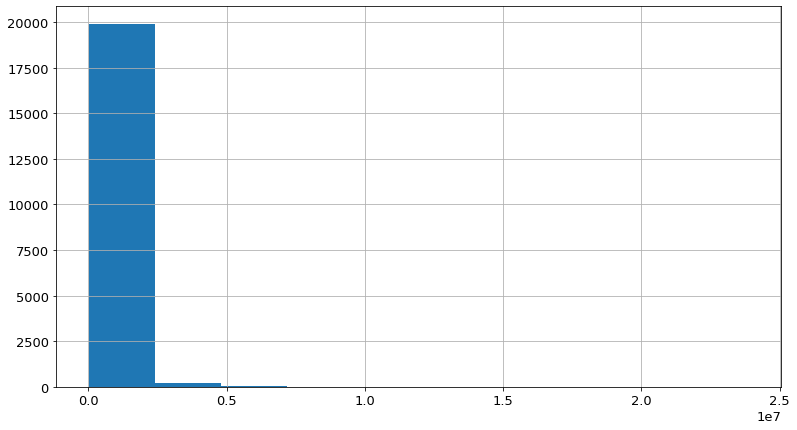

In [44]:
# Plot the distribution of the target variable: taxvaluedollarcnt

df.taxvaluedollarcnt.hist()

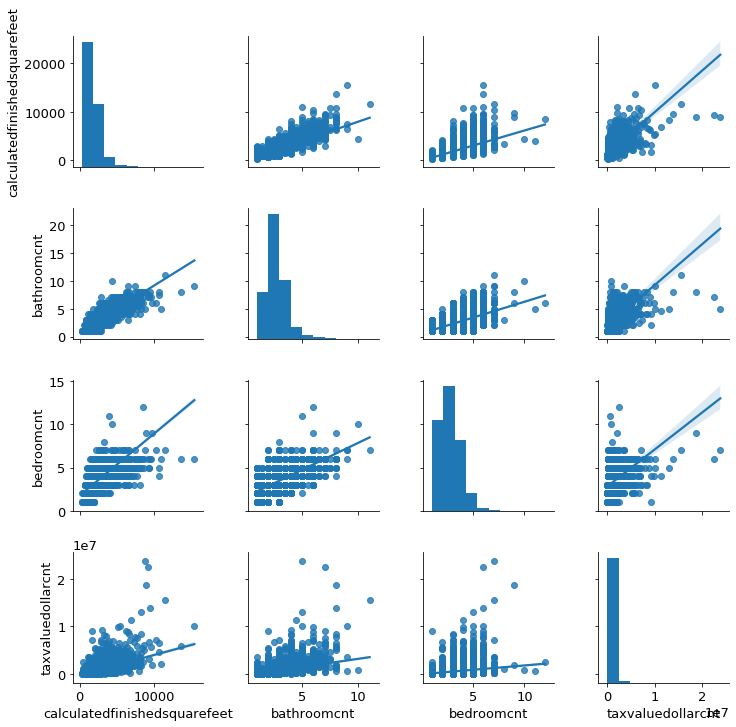

In [45]:
# Pairplot the variables

sns.pairplot(df, kind='reg')

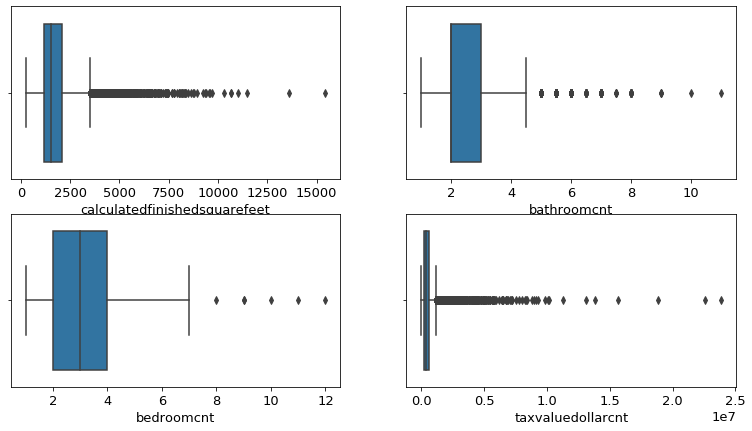

In [46]:
# Box-plot all the variables

plt.subplot(221)
sns.boxplot(df.calculatedfinishedsquarefeet)

plt.subplot(222)
sns.boxplot(df.bathroomcnt)

plt.subplot(223)
sns.boxplot(df.bedroomcnt)

plt.subplot(224)
sns.boxplot(df.taxvaluedollarcnt)

### Splitting the data into train, validate and test

In [47]:
df.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
0,1458.0,2.0,3.0,136104.0
1,1421.0,1.0,2.0,35606.0
2,2541.0,3.0,4.0,880456.0
3,1650.0,2.0,3.0,614000.0
4,693.0,1.0,2.0,274237.0


In [48]:
df.taxvaluedollarcnt

0        136104.0
1         35606.0
2        880456.0
3        614000.0
4        274237.0
           ...   
20160    359829.0
20161    297097.0
20162    746963.0
20163    579047.0
20164    630933.0
Name: taxvaluedollarcnt, Length: 20165, dtype: float64

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20165 entries, 0 to 20164
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20165 non-null  float64
 1   bathroomcnt                   20165 non-null  float64
 2   bedroomcnt                    20165 non-null  float64
 3   taxvaluedollarcnt             20165 non-null  float64
dtypes: float64(4)
memory usage: 630.3 KB


In [50]:
# from sklearn.model_selection import train_test_split

# train_validate, test = train_test_split(df, test_size=0.2, 
#                                             random_state=123,
#                                             stratify=df.taxvaluedollarcnt
#                                            )

In [51]:
import prepare

train, validate, test = prepare.split_my_data(df, pct=0.1)
train.shape, validate.shape, test.shape

((14518, 4), (3630, 4), (2017, 4))

In [52]:
train.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
16476,1476.0,2.0,3.0,409397.0
17919,1603.0,2.0,3.0,231346.0
3622,1579.0,2.0,3.0,169559.0
16863,1458.0,2.5,2.0,225597.0
15808,2338.0,3.0,4.0,288753.0


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14518 entries, 16476 to 18804
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  14518 non-null  float64
 1   bathroomcnt                   14518 non-null  float64
 2   bedroomcnt                    14518 non-null  float64
 3   taxvaluedollarcnt             14518 non-null  float64
dtypes: float64(4)
memory usage: 567.1 KB


In [54]:
# # Value error when I tried to stratify the target variables

# train_stratified, validate_stratified, test_stratified = prepare.split_stratify_my_data(df,
#                                                                                         'taxvaluedollarcnt',
#                                                                                         pct=0.1)
# train_stratified.shape, validate_stratified.shape, test_stratified.shape

In [55]:
scaler, train_scaled, validate_scaled, test_scaled = prepare.min_max_scaler(train, validate, test)
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((14518, 4), (3630, 4), (2017, 4))

In [56]:
train_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
16476,0.114492,0.111111,0.222222,0.017615
17919,0.126276,0.111111,0.222222,0.009729
3622,0.124049,0.111111,0.222222,0.006993
16863,0.112822,0.166667,0.111111,0.009475
15808,0.194470,0.222222,0.333333,0.012272


In [57]:
def prep_zillow(zillow):
    """
    Accpet the zillow dataframe acquired by function acquire_cache_data in acquire.py
    Return three splited dataframes scaled by min_max scaler: train_scaled, validate_scaled, test_scaled
    """
    mask_bathr = (zillow.bathroomcnt == 0)
    mask_bedr = (zillow.bedroomcnt == 0)
    mask_sf = zillow.calculatedfinishedsquarefeet.isnull()
    mask = mask_bathr | mask_bedr | mask_sf
    zillow = zillow[-mask]
    zillow = zillow.drop_duplicates(keep='first', ignore_index=True)
    train, validate, test = prepare.split_my_data(zillow, pct=0.1)
    scaler, train_scaled, validate_scaled, test_scaled = prepare.min_max_scaler(train, validate, test)
    return train_scaled, validate_scaled, test_scaled

In [58]:
zillow = acquire.acquire_cache_data()
zillow.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
0,1458.0,2.0,3.0,136104.0
1,1421.0,1.0,2.0,35606.0
2,2541.0,3.0,4.0,880456.0
3,1650.0,2.0,3.0,614000.0
4,693.0,1.0,2.0,274237.0


In [59]:
train_scaled, validate_scaled, test_scaled = prepare.prep_zillow(zillow)
train_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
16476,0.114492,0.111111,0.222222,0.017615
17919,0.126276,0.111111,0.222222,0.009729
3622,0.124049,0.111111,0.222222,0.006993
16863,0.112822,0.166667,0.111111,0.009475
15808,0.194470,0.222222,0.333333,0.012272


In [60]:
validate_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
13876,0.261459,0.388889,0.333333,0.020078
6471,0.134348,0.111111,0.333333,0.028051
8096,0.072370,0.055556,0.222222,0.020477
95,0.358415,0.333333,0.555556,0.017081
4969,0.132214,0.111111,0.111111,0.039345


In [61]:
test_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
18614,0.147152,0.222222,0.333333,0.038559
17346,0.047783,0.000000,0.111111,0.003003
7558,0.096957,0.166667,0.222222,0.011701
8780,0.142605,0.111111,0.222222,0.029557
8940,0.121451,0.111111,0.222222,0.016871


## Modeling
- MVP:
    - X: 'calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt'
    - y: 'taxvaluedollarcnt'

In [62]:
train_scaled.columns

Index(['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt',
       'taxvaluedollarcnt'],
      dtype='object')

In [63]:
# Create X and y

X_train_scaled = train_scaled[['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt']]
y_train_scaled = train_scaled['taxvaluedollarcnt']

### Set up baseline

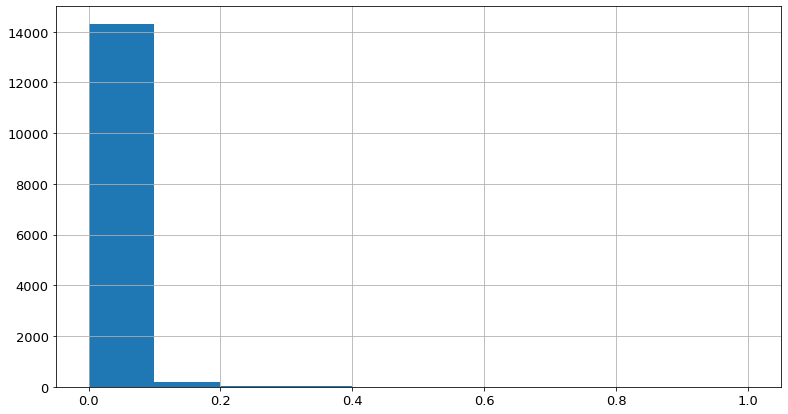

In [64]:
train_scaled.taxvaluedollarcnt.hist()

In [65]:
mean, median = train_scaled.taxvaluedollarcnt.agg(['mean', 'median'])
mean, median

(0.021679118375542906, 0.015692126737139968)

In [66]:
# Compute baseline prediction using mean

baseline = np.array([mean]*train_scaled.shape[0])
baseline[:5], len(baseline)

(array([0.02167912, 0.02167912, 0.02167912, 0.02167912, 0.02167912]), 14518)

In [67]:
# Compute baseline sse

baseline_residual = y_train_scaled - mean
baseline_sse = (baseline_residual**2).sum()
baseline_sse

11.533542707108785

In [68]:
# Compute baseline mse

baseline_mse = baseline_sse/train_scaled.shape[0]
baseline_mse

0.0007944305487745409

In [69]:
# Compute baseline rmse

baseline_rmse = mean_squared_error(y_train_scaled, baseline)**1/2
baseline_rmse

0.00039721527438727047

### Test 3 different algorithms for MVP
- LinearRegression
- LassoLars
- PolynomialFeatures + LinearRegression (2nd degree)

In [70]:
X_train_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt
16476,0.114492,0.111111,0.222222
17919,0.126276,0.111111,0.222222
3622,0.124049,0.111111,0.222222
16863,0.112822,0.166667,0.111111
15808,0.194470,0.222222,0.333333


In [71]:
y_train_scaled

16476    0.017615
17919    0.009729
3622     0.006993
16863    0.009475
15808    0.012272
           ...   
17329    0.017603
2367     0.023546
13173    0.026566
9199     0.004336
18804    0.002049
Name: taxvaluedollarcnt, Length: 14518, dtype: float64

### LinearRegression

In [72]:
# Create, fit, predict and calculate the lm_rmse

lm = LinearRegression(normalize=True)
lm.fit(X_train_scaled, y_train_scaled)
lm_pred = lm.predict(X_train_scaled)
lm_rmse = mean_squared_error(y_train_scaled, lm_pred)**1/2

lm_rmse

0.00024919734598661327

### LassoLars() for MVP

In [73]:
# Create, fit, predict and calculate the lars_rmse

lars = LassoLars(alpha=0.1)
lars.fit(X_train_scaled, y_train_scaled)
lars_pred = lars.predict(X_train_scaled)
lars_rmse = mean_squared_error(y_train_scaled, lars_pred)**1/2

lars_rmse

0.0003972152743872705

### PolynomialFeatures + LinearRegression
2nd degress polynomial

In [74]:
pf = PolynomialFeatures(degree=2)
X_train_scaled_squared = pf.fit_transform(X_train_scaled)

lm_squared = LinearRegression()
lm_squared.fit(X_train_scaled_squared, y_train_scaled)
lm_squared_pred = lm_squared.predict(X_train_scaled_squared)

lm_squared_rmse = mean_squared_error(y_train_scaled, lm_squared_pred)**1/2
lm_squared_rmse

0.0002332039338713283

### Validate top 2 algorithms for MVP
- LinearRegression
- PolynomialFeatures + LinearRegression (2nd degree)

In [75]:
# Create X and y

X_validate_scaled = validate_scaled[['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt']]
y_validate_scaled = validate_scaled['taxvaluedollarcnt']

In [76]:
validate_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
13876,0.261459,0.388889,0.333333,0.020078
6471,0.134348,0.111111,0.333333,0.028051
8096,0.072370,0.055556,0.222222,0.020477
95,0.358415,0.333333,0.555556,0.017081
4969,0.132214,0.111111,0.111111,0.039345


In [77]:
X_validate_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt
13876,0.261459,0.388889,0.333333
6471,0.134348,0.111111,0.333333
8096,0.072370,0.055556,0.222222
95,0.358415,0.333333,0.555556
4969,0.132214,0.111111,0.111111


In [78]:
y_validate_scaled.head()

13876    0.020078
6471     0.028051
8096     0.020477
95       0.017081
4969     0.039345
Name: taxvaluedollarcnt, dtype: float64

### LinearRegression

In [79]:
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [80]:
lm_pred = lm.predict(X_validate_scaled)
lm_rmse = mean_squared_error(y_validate_scaled, lm_pred)**1/2

lm_rmse

0.000344478679726347

### PolynomialFeatures + LinearRegression
2nd degress polynomial

In [81]:
pf

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [82]:
X_validate_scaled_squared = pf.transform(X_validate_scaled)
lm_squared_pred = lm_squared.predict(X_validate_scaled_squared)

lm_squared_rmse = mean_squared_error(y_validate_scaled, lm_squared_pred)**1/2
lm_squared_rmse

0.0003049063569313912

## Test 
### PolynomialFeatures + LinearRegression
2nd degress polynomial

In [87]:
test_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
18614,0.147152,0.222222,0.333333,0.038559
17346,0.047783,0.000000,0.111111,0.003003
7558,0.096957,0.166667,0.222222,0.011701
8780,0.142605,0.111111,0.222222,0.029557
8940,0.121451,0.111111,0.222222,0.016871


In [83]:
# Create X and y

X_test_scaled = test_scaled[['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt']]
y_test_scaled = test_scaled['taxvaluedollarcnt']

In [84]:
X_test_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt
18614,0.147152,0.222222,0.333333
17346,0.047783,0.000000,0.111111
7558,0.096957,0.166667,0.222222
8780,0.142605,0.111111,0.222222
8940,0.121451,0.111111,0.222222


In [86]:
y_test_scaled.head()

18614    0.038559
17346    0.003003
7558     0.011701
8780     0.029557
8940     0.016871
Name: taxvaluedollarcnt, dtype: float64

In [ ]:
X_test_scaled_squared = pf.transform(X_test_scaled)
lm_squared_pred = lm_squared.predict(X_test_scaled_squared)

lm_squared_rmse = mean_squared_error(y_test_scaled, lm_squared_pred)**1/2
lm_squared_rmse

# 2nd Iteration

### Data Acquisition

In [164]:
query = """
        SELECT *
        FROM properties_2017 AS p
        JOIN predictions_2017 AS pr USING (parcelid) 
        WHERE p.propertylandusetypeid IN (261, 262, 263, 264, 266, 268, 273, 275, 276, 279)
        AND pr.transactiondate between '2017-05-01' AND '2017-06-30'
        """

def get_zillow_data(iteration):
    zillow_csv = 'zillow_' + iteration + '.csv'
    filename = zillow_csv
    
    if os.path.isfile(filename):
        return pd.read_csv(filename, index_col=0)
    else:
        df = pd.read_sql(query, get_connection('zillow'))
        df.to_csv(filename)
        return df

In [165]:
df2 = get_zillow_data('2')
df2.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
1,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30
2,14269464,1923117,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,...,880456.0,2016.0,445569.0,9819.72,NaN,NaN,6.059064e+13,2028,0.021085,2017-06-01
3,11389003,2121349,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,614000.0,2016.0,449000.0,7673.19,NaN,NaN,6.037703e+13,3273,-0.325393,2017-06-01
4,11967869,2093710,NaN,NaN,NaN,1.0,2.0,NaN,5.0,1.0,...,274237.0,2016.0,191821.0,3267.47,NaN,NaN,6.037185e+13,3429,-0.005566,2017-06-29


In [166]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20364 entries, 0 to 20363
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      20364 non-null  int64  
 1   id                            20364 non-null  int64  
 2   airconditioningtypeid         6506 non-null   float64
 3   architecturalstyletypeid      49 non-null     float64
 4   basementsqft                  11 non-null     float64
 5   bathroomcnt                   20364 non-null  float64
 6   bedroomcnt                    20364 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         12623 non-null  float64
 9   calculatedbathnbr             20288 non-null  float64
 10  decktypeid                    175 non-null    float64
 11  finishedfloor1squarefeet      1671 non-null   float64
 12  calculatedfinishedsquarefeet  20318 non-null  float64
 13  f

### Filter features by the percentage of null values

In [167]:
# Compute the percentage of null values for each column. 

cols = df2.columns.tolist()
percentages = []
n_rows = df2.shape[0]

for col in cols:
    percentage = df2[col].isnull().sum()/n_rows
    percentages.append(percentage)
    
null_percentage = pd.DataFrame(percentages, index = cols)
null_percentage

,0
parcelid,0.000000
id,0.000000
airconditioningtypeid,0.680515
architecturalstyletypeid,0.997594
basementsqft,0.999460
...,...
taxdelinquencyyear,0.967344
censustractandblock,0.003781
id.1,0.000000
logerror,0.000000


In [168]:
# Select all the cols that have less than 20% of null values

mask = null_percentage[0] < 0.2
null_percentage[mask]

,0
parcelid,0.000000
id,0.000000
bathroomcnt,0.000000
bedroomcnt,0.000000
calculatedbathnbr,0.003732
calculatedfinishedsquarefeet,0.002259
finishedsquarefeet12,0.005107
fips,0.000000
fullbathcnt,0.003732
latitude,0.000000


### Initial visualization of selected variables

In [191]:
# Selected variables

features_target = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                   'fips', 'latitude', 'longitude', 
                   'lotsizesquarefeet', 'propertycountylandusecode','rawcensustractandblock', 
                   'regionidcity', 'regionidcounty','regionidzip',
                   'yearbuilt', 'censustractandblock', 'logerror', 
                   'taxvaluedollarcnt']

features = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
            'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'propertycountylandusecode',
            'rawcensustractandblock', 'regionidcity', 'regionidcounty','regionidzip',
            'yearbuilt', 'censustractandblock', 'logerror']

target = ['taxvaluedollarcnt']


df_vis = df2[features_target]
df_vis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20364 entries, 0 to 20363
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   20364 non-null  float64
 1   bedroomcnt                    20364 non-null  float64
 2   calculatedfinishedsquarefeet  20318 non-null  float64
 3   fips                          20364 non-null  float64
 4   latitude                      20364 non-null  float64
 5   longitude                     20364 non-null  float64
 6   lotsizesquarefeet             18104 non-null  float64
 7   propertycountylandusecode     20364 non-null  object 
 8   rawcensustractandblock        20364 non-null  float64
 9   regionidcity                  19999 non-null  float64
 10  regionidcounty                20364 non-null  float64
 11  regionidzip                   20350 non-null  float64
 12  yearbuilt                     20302 non-null  float64
 13  c

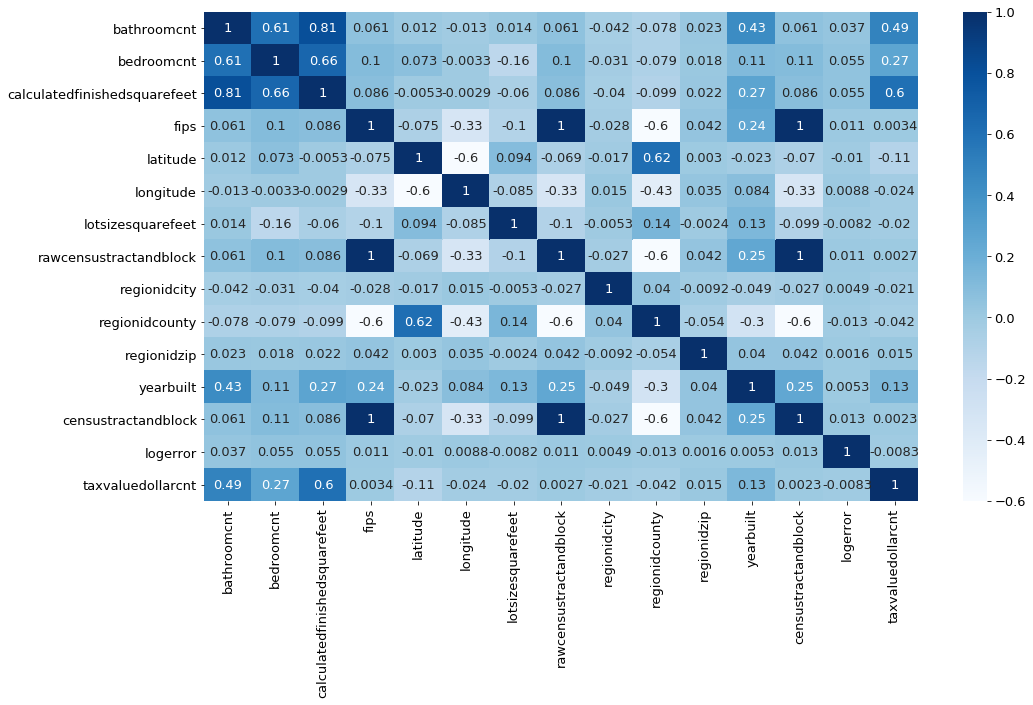

In [61]:
# corr_heatmap

corr = df_vis.corr()
sns.heatmap(corr, cmap='Blues', annot=True)

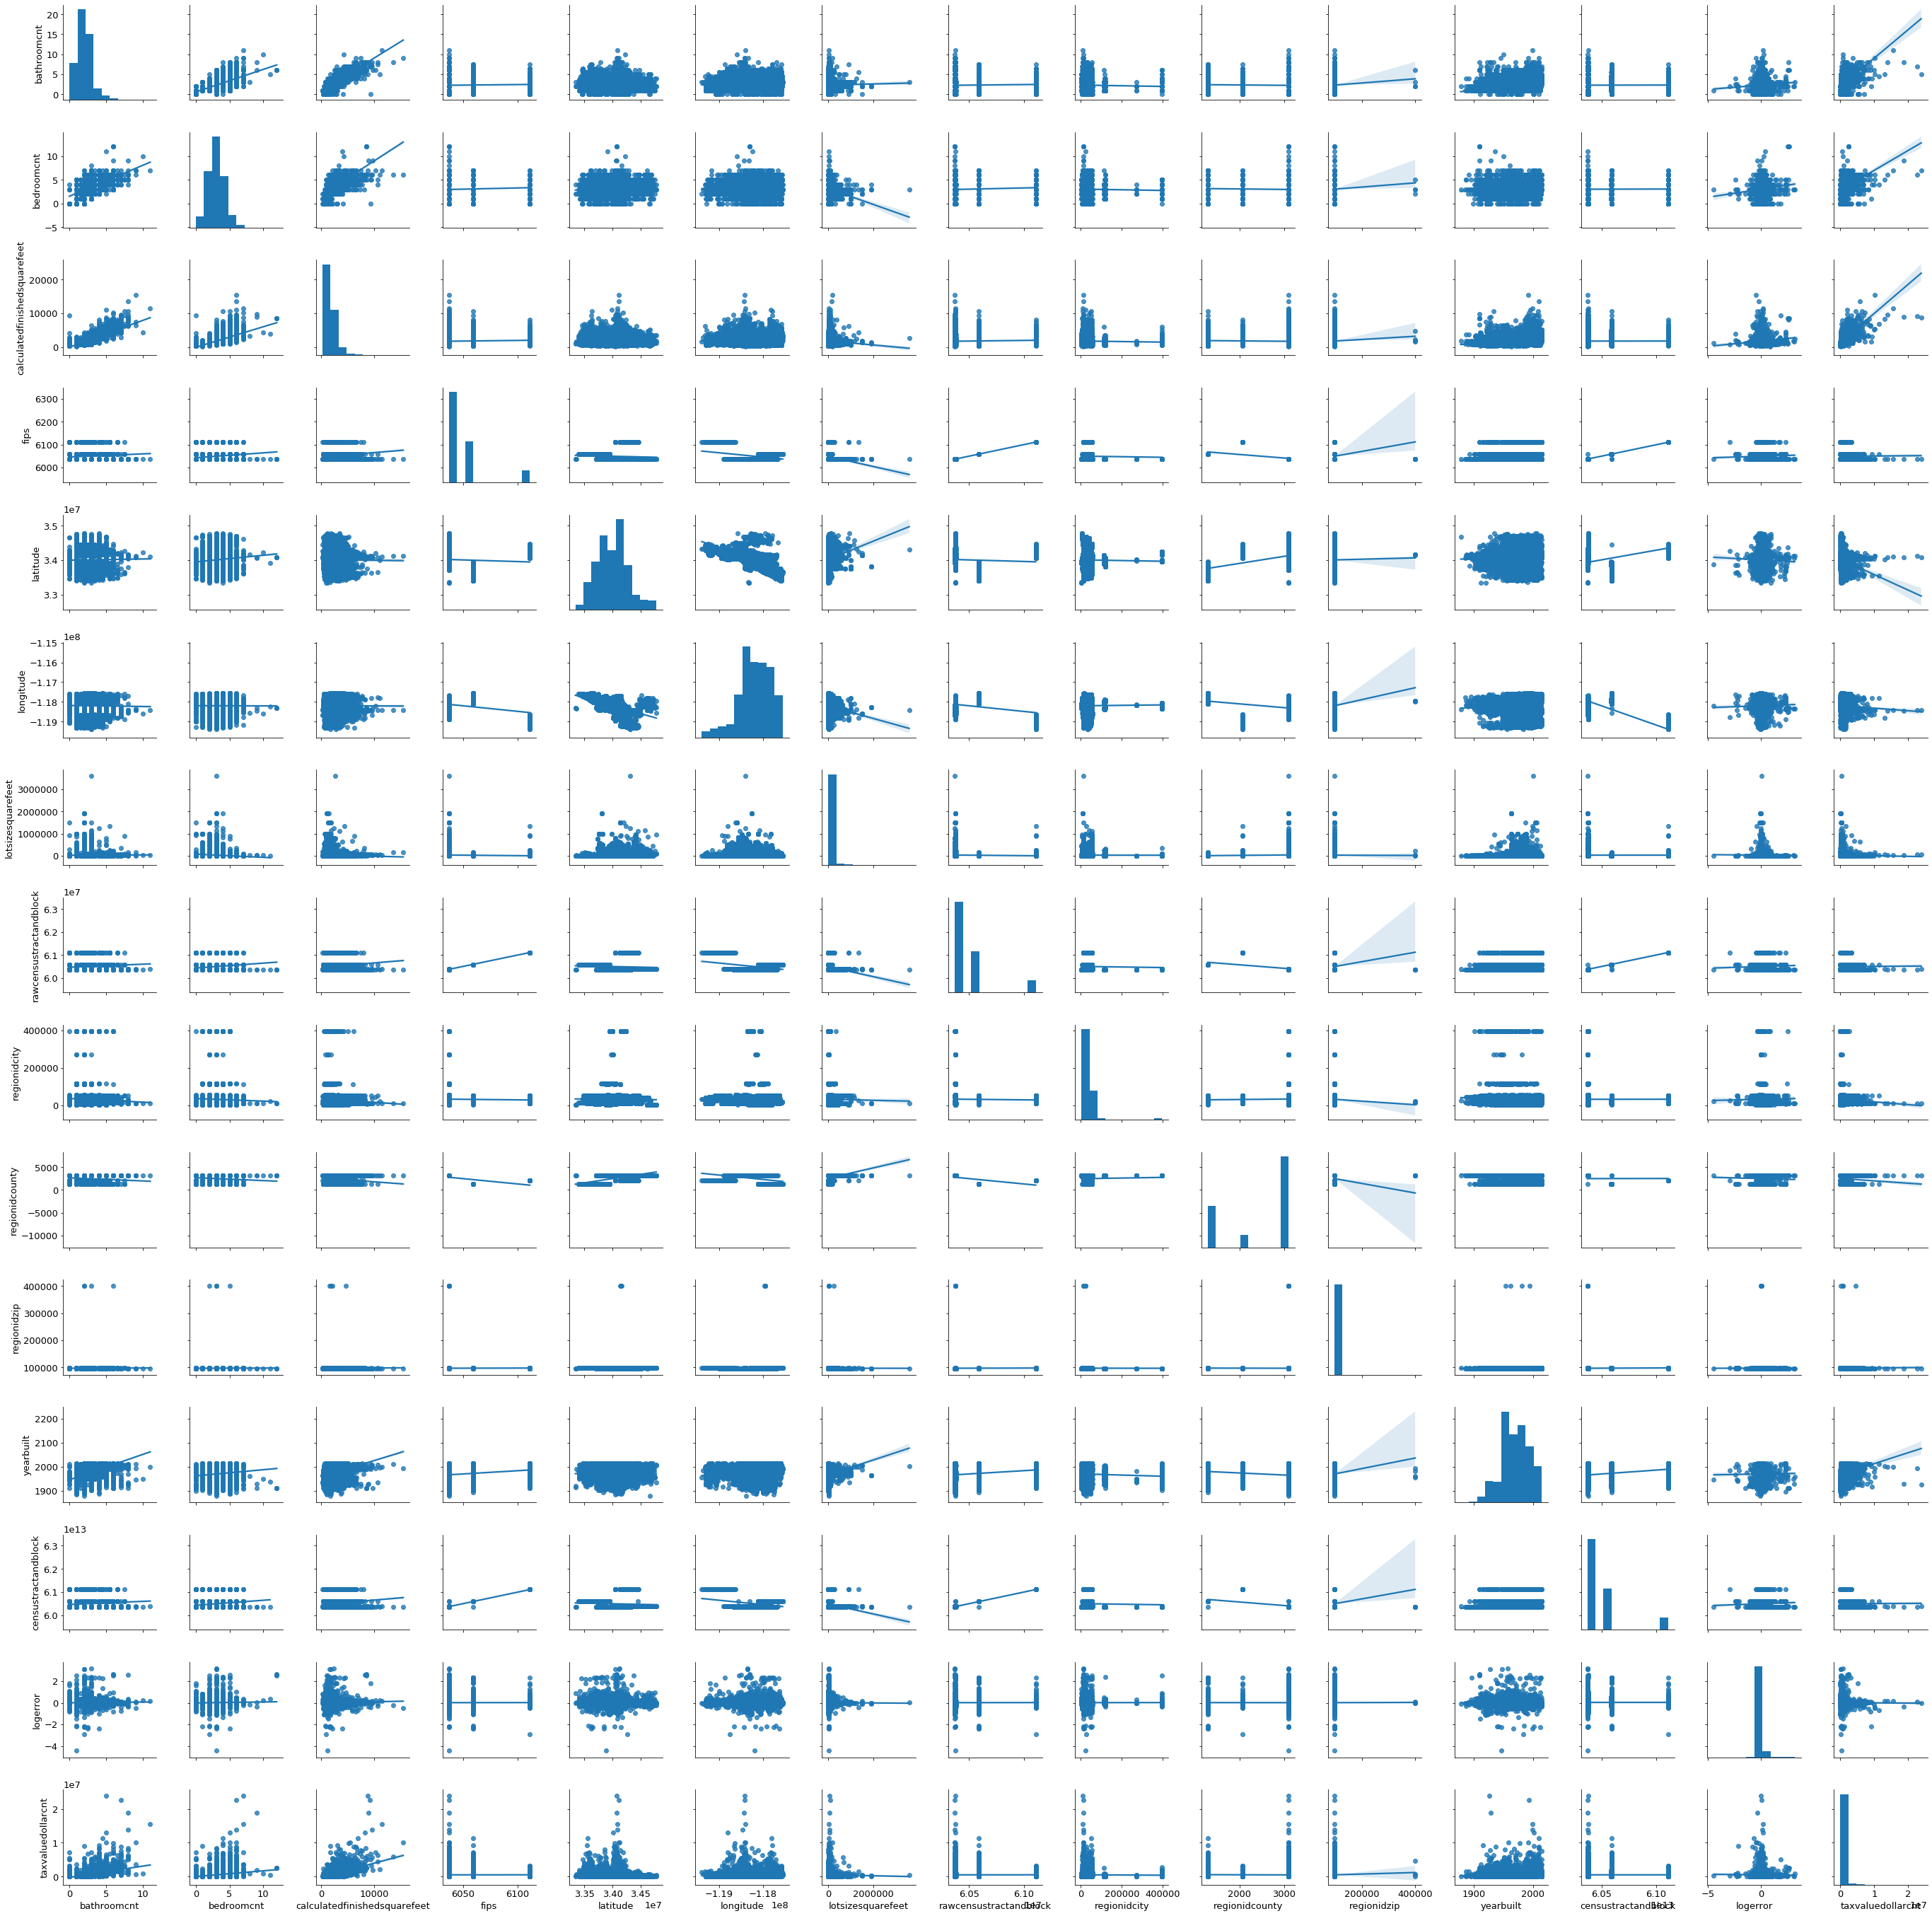

In [63]:
# Pairplot of selected features against target varibale

sns.pairplot(df_vis, kind='reg')

In [170]:
df_vis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20364 entries, 0 to 20363
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   20364 non-null  float64
 1   bedroomcnt                    20364 non-null  float64
 2   calculatedfinishedsquarefeet  20318 non-null  float64
 3   fips                          20364 non-null  float64
 4   latitude                      20364 non-null  float64
 5   longitude                     20364 non-null  float64
 6   lotsizesquarefeet             18104 non-null  float64
 7   propertycountylandusecode     20364 non-null  object 
 8   rawcensustractandblock        20364 non-null  float64
 9   regionidcity                  19999 non-null  float64
 10  regionidcounty                20364 non-null  float64
 11  regionidzip                   20350 non-null  float64
 12  yearbuilt                     20302 non-null  float64
 13  c

**Takeways**
1. fips are the same as rawcensustractandblock and censustractandblock since their correlations are 1.
2. the data needs to be prepared before feature engineering:
    - fips: convert to the name and get the dummies

### Data Preparation

In [192]:
# Create the dataframe that need to be wrangled

features = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
            'fips', 'latitude', 'longitude',
            'lotsizesquarefeet', 'propertycountylandusecode', 'regionidcity', 
            'regionidcounty', 'regionidzip', 'yearbuilt', 
            'logerror']

target = ['taxvaluedollarcnt']

features_target = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                   'fips', 'latitude', 'longitude',
                   'lotsizesquarefeet', 'propertycountylandusecode', 'regionidcity', 
                   'regionidcounty', 'regionidzip', 'yearbuilt', 
                   'logerror', 
                   'taxvaluedollarcnt']

zillow2 = df2[features_target]
zillow2.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidcounty,regionidzip,yearbuilt,logerror,taxvaluedollarcnt
0,2.0,3.0,1458.0,6037.0,34686163.0,-118113100.0,8284.0,0101,5534.0,3101.0,97318.0,1970.0,-0.362001,136104.0
1,1.0,2.0,1421.0,6037.0,33999877.0,-118291863.0,6707.0,0100,12447.0,3101.0,96018.0,1911.0,-0.146056,35606.0
2,3.0,4.0,2541.0,6059.0,33694636.0,-117912245.0,4975.0,1,38032.0,1286.0,96958.0,2003.0,0.021085,880456.0
3,2.0,3.0,1650.0,6037.0,33985377.0,-118361620.0,7300.0,0100,396550.0,3101.0,96037.0,1949.0,-0.325393,614000.0
4,1.0,2.0,693.0,6037.0,34112946.0,-118208106.0,2908.0,0100,12447.0,3101.0,96023.0,1921.0,-0.005566,274237.0


In [193]:
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20364 entries, 0 to 20363
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   20364 non-null  float64
 1   bedroomcnt                    20364 non-null  float64
 2   calculatedfinishedsquarefeet  20318 non-null  float64
 3   fips                          20364 non-null  float64
 4   latitude                      20364 non-null  float64
 5   longitude                     20364 non-null  float64
 6   lotsizesquarefeet             18104 non-null  float64
 7   propertycountylandusecode     20364 non-null  object 
 8   regionidcity                  19999 non-null  float64
 9   regionidcounty                20364 non-null  float64
 10  regionidzip                   20350 non-null  float64
 11  yearbuilt                     20302 non-null  float64
 12  logerror                      20364 non-null  float64
 13  t

In [194]:
# Drop the observations with missing values

cols = zillow2.columns.tolist()

for col in cols:
    mask = zillow2[col].isnull()
    zillow2 = zillow2[-mask]
    
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17721 entries, 0 to 20363
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   17721 non-null  float64
 1   bedroomcnt                    17721 non-null  float64
 2   calculatedfinishedsquarefeet  17721 non-null  float64
 3   fips                          17721 non-null  float64
 4   latitude                      17721 non-null  float64
 5   longitude                     17721 non-null  float64
 6   lotsizesquarefeet             17721 non-null  float64
 7   propertycountylandusecode     17721 non-null  object 
 8   regionidcity                  17721 non-null  float64
 9   regionidcounty                17721 non-null  float64
 10  regionidzip                   17721 non-null  float64
 11  yearbuilt                     17721 non-null  float64
 12  logerror                      17721 non-null  float64
 13  t

In [195]:
zillow2.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidcounty,regionidzip,yearbuilt,logerror,taxvaluedollarcnt
0,2.0,3.0,1458.0,6037.0,34686163.0,-118113100.0,8284.0,0101,5534.0,3101.0,97318.0,1970.0,-0.362001,136104.0
1,1.0,2.0,1421.0,6037.0,33999877.0,-118291863.0,6707.0,0100,12447.0,3101.0,96018.0,1911.0,-0.146056,35606.0
2,3.0,4.0,2541.0,6059.0,33694636.0,-117912245.0,4975.0,1,38032.0,1286.0,96958.0,2003.0,0.021085,880456.0
3,2.0,3.0,1650.0,6037.0,33985377.0,-118361620.0,7300.0,0100,396550.0,3101.0,96037.0,1949.0,-0.325393,614000.0
4,1.0,2.0,693.0,6037.0,34112946.0,-118208106.0,2908.0,0100,12447.0,3101.0,96023.0,1921.0,-0.005566,274237.0


In [196]:
# Drop the duplicates

zillow2 = zillow2.drop_duplicates(keep='first', ignore_index=True)
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17720 entries, 0 to 17719
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   17720 non-null  float64
 1   bedroomcnt                    17720 non-null  float64
 2   calculatedfinishedsquarefeet  17720 non-null  float64
 3   fips                          17720 non-null  float64
 4   latitude                      17720 non-null  float64
 5   longitude                     17720 non-null  float64
 6   lotsizesquarefeet             17720 non-null  float64
 7   propertycountylandusecode     17720 non-null  object 
 8   regionidcity                  17720 non-null  float64
 9   regionidcounty                17720 non-null  float64
 10  regionidzip                   17720 non-null  float64
 11  yearbuilt                     17720 non-null  float64
 12  logerror                      17720 non-null  float64
 13  t

In [197]:
zillow2.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidcounty,regionidzip,yearbuilt,logerror,taxvaluedollarcnt
0,2.0,3.0,1458.0,6037.0,34686163.0,-118113100.0,8284.0,0101,5534.0,3101.0,97318.0,1970.0,-0.362001,136104.0
1,1.0,2.0,1421.0,6037.0,33999877.0,-118291863.0,6707.0,0100,12447.0,3101.0,96018.0,1911.0,-0.146056,35606.0
2,3.0,4.0,2541.0,6059.0,33694636.0,-117912245.0,4975.0,1,38032.0,1286.0,96958.0,2003.0,0.021085,880456.0
3,2.0,3.0,1650.0,6037.0,33985377.0,-118361620.0,7300.0,0100,396550.0,3101.0,96037.0,1949.0,-0.325393,614000.0
4,1.0,2.0,693.0,6037.0,34112946.0,-118208106.0,2908.0,0100,12447.0,3101.0,96023.0,1921.0,-0.005566,274237.0


In [198]:
# Check the categorical variables

zillow2.fips.value_counts()

6037.0    12222
6059.0     4085
6111.0     1413
Name: fips, dtype: int64

In [199]:
zillow2.regionidcounty.value_counts()

3101.0    12222
1286.0     4085
2061.0     1413
Name: regionidcounty, dtype: int64

In [200]:
zillow2.regionidzip.value_counts().size

381

In [201]:
zillow2.regionidcity.value_counts().size

170

In [202]:
zillow2.propertycountylandusecode.value_counts().size

28

**Takeways**
1. fips and regionidcounty has the exactly the same counts so they are the same thing. Hence, drop the regionidcounty.

In [203]:
zillow2.drop(columns='regionidcounty', inplace=True)
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17720 entries, 0 to 17719
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   17720 non-null  float64
 1   bedroomcnt                    17720 non-null  float64
 2   calculatedfinishedsquarefeet  17720 non-null  float64
 3   fips                          17720 non-null  float64
 4   latitude                      17720 non-null  float64
 5   longitude                     17720 non-null  float64
 6   lotsizesquarefeet             17720 non-null  float64
 7   propertycountylandusecode     17720 non-null  object 
 8   regionidcity                  17720 non-null  float64
 9   regionidzip                   17720 non-null  float64
 10  yearbuilt                     17720 non-null  float64
 11  logerror                      17720 non-null  float64
 12  taxvaluedollarcnt             17720 non-null  float64
dtypes

In [204]:
zillow2.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidzip,yearbuilt,logerror,taxvaluedollarcnt
0,2.0,3.0,1458.0,6037.0,34686163.0,-118113100.0,8284.0,0101,5534.0,97318.0,1970.0,-0.362001,136104.0
1,1.0,2.0,1421.0,6037.0,33999877.0,-118291863.0,6707.0,0100,12447.0,96018.0,1911.0,-0.146056,35606.0
2,3.0,4.0,2541.0,6059.0,33694636.0,-117912245.0,4975.0,1,38032.0,96958.0,2003.0,0.021085,880456.0
3,2.0,3.0,1650.0,6037.0,33985377.0,-118361620.0,7300.0,0100,396550.0,96037.0,1949.0,-0.325393,614000.0
4,1.0,2.0,693.0,6037.0,34112946.0,-118208106.0,2908.0,0100,12447.0,96023.0,1921.0,-0.005566,274237.0


In [205]:
# Convert fips to county names

zillow2.fips = zillow2.apply(acquire.add_county_column, axis=1)
zillow2.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidzip,yearbuilt,logerror,taxvaluedollarcnt
0,2.0,3.0,1458.0,Los Angeles,34686163.0,-118113100.0,8284.0,0101,5534.0,97318.0,1970.0,-0.362001,136104.0
1,1.0,2.0,1421.0,Los Angeles,33999877.0,-118291863.0,6707.0,0100,12447.0,96018.0,1911.0,-0.146056,35606.0
2,3.0,4.0,2541.0,Orange,33694636.0,-117912245.0,4975.0,1,38032.0,96958.0,2003.0,0.021085,880456.0
3,2.0,3.0,1650.0,Los Angeles,33985377.0,-118361620.0,7300.0,0100,396550.0,96037.0,1949.0,-0.325393,614000.0
4,1.0,2.0,693.0,Los Angeles,34112946.0,-118208106.0,2908.0,0100,12447.0,96023.0,1921.0,-0.005566,274237.0


In [206]:
# Dummy encode fips, drop_first=False

def encode_label(df, columns_to_encode):
    """
    Dummy coding of categorical varibales
    Parameters: df, columns_to_encode(list)
    """
    obj_df = df[columns_to_encode]
    dummy_df = pd.get_dummies(obj_df, dummy_na=False)
    df = pd.concat([df, dummy_df], axis=1)
    df.drop(columns=columns_to_encode, inplace=True)
    return df

In [207]:
zillow2 = encode_label(zillow2, ['fips'])
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17720 entries, 0 to 17719
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   17720 non-null  float64
 1   bedroomcnt                    17720 non-null  float64
 2   calculatedfinishedsquarefeet  17720 non-null  float64
 3   latitude                      17720 non-null  float64
 4   longitude                     17720 non-null  float64
 5   lotsizesquarefeet             17720 non-null  float64
 6   propertycountylandusecode     17720 non-null  object 
 7   regionidcity                  17720 non-null  float64
 8   regionidzip                   17720 non-null  float64
 9   yearbuilt                     17720 non-null  float64
 10  logerror                      17720 non-null  float64
 11  taxvaluedollarcnt             17720 non-null  float64
 12  fips_Los Angeles              17720 non-null  uint8  
 13  f

**Takeaways**
- After discussed with Adam, we agree to drop columns propertycountylandusecode, regionidcity, regionidzip, because their values have little meaning unless we assign them to specific locations.

In [208]:
zillow2.drop(columns = ['propertycountylandusecode', 'regionidcity', 'regionidzip'], inplace=True)
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17720 entries, 0 to 17719
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   17720 non-null  float64
 1   bedroomcnt                    17720 non-null  float64
 2   calculatedfinishedsquarefeet  17720 non-null  float64
 3   latitude                      17720 non-null  float64
 4   longitude                     17720 non-null  float64
 5   lotsizesquarefeet             17720 non-null  float64
 6   yearbuilt                     17720 non-null  float64
 7   logerror                      17720 non-null  float64
 8   taxvaluedollarcnt             17720 non-null  float64
 9   fips_Los Angeles              17720 non-null  uint8  
 10  fips_Orange                   17720 non-null  uint8  
 11  fips_Ventura                  17720 non-null  uint8  
dtypes: float64(9), uint8(3)
memory usage: 1.3 MB


### Split zillow2 dataset

In [210]:
train, validate, test = prepare.split_my_data(zillow2, pct=0.1)
train.shape, validate.shape, test.shape

((12758, 12), (3190, 12), (1772, 12))

In [211]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12758 entries, 2459 to 7496
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   12758 non-null  float64
 1   bedroomcnt                    12758 non-null  float64
 2   calculatedfinishedsquarefeet  12758 non-null  float64
 3   latitude                      12758 non-null  float64
 4   longitude                     12758 non-null  float64
 5   lotsizesquarefeet             12758 non-null  float64
 6   yearbuilt                     12758 non-null  float64
 7   logerror                      12758 non-null  float64
 8   taxvaluedollarcnt             12758 non-null  float64
 9   fips_Los Angeles              12758 non-null  uint8  
 10  fips_Orange                   12758 non-null  uint8  
 11  fips_Ventura                  12758 non-null  uint8  
dtypes: float64(9), uint8(3)
memory usage: 1.0 MB


### Scale all features
- X_train: 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude','longitude', 'lotsizesquarefeet', 'yearbuilt', 'logerror', 'fips_Los Angeles', 'fips_Orange', 'fips_Ventura'
- y_train: 'taxvaluedollarcnt'

In [212]:
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,yearbuilt,logerror,taxvaluedollarcnt,fips_Los Angeles,fips_Orange,fips_Ventura
2459,3.0,3.0,2279.0,34121453.0,-118083479.0,9505.0,1948.0,-0.009300,1066356.0,1,0,0
13744,2.0,3.0,1477.0,34084794.0,-117914745.0,8245.0,1953.0,-0.023016,74087.0,1,0,0
15417,3.0,3.0,2895.0,34627416.0,-118185186.0,118977.0,2007.0,0.008795,566600.0,1,0,0
3257,1.0,2.0,795.0,34142400.0,-117917000.0,29390.0,1979.0,-0.026826,218000.0,1,0,0
3093,2.0,2.0,974.0,34212886.0,-118431196.0,6116.0,1951.0,-0.086502,203860.0,1,0,0


In [220]:
# Create train, validate, test of X and y

X_train = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                'latitude','longitude', 'lotsizesquarefeet',
                'yearbuilt', 'logerror', 'fips_Los Angeles', 
                'fips_Orange', 'fips_Ventura']]

y_train = train['taxvaluedollarcnt']

X_validate = validate[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                'latitude','longitude', 'lotsizesquarefeet',
                'yearbuilt', 'logerror', 'fips_Los Angeles', 
                'fips_Orange', 'fips_Ventura']]

y_validate = validate['taxvaluedollarcnt']

X_test = test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                'latitude','longitude', 'lotsizesquarefeet',
                'yearbuilt', 'logerror', 'fips_Los Angeles', 
                'fips_Orange', 'fips_Ventura']]

y_test = test['taxvaluedollarcnt']

X_train.shape, X_validate.shape, X_test.shape

((12758, 11), (3190, 11), (1772, 11))

In [228]:
y_train.shape, y_validate.shape, y_test.shape

((12758,), (3190,), (1772,))

In [219]:
# Scale X_train, X_validate, X_test

scaler, X_train_scaled, X_validate_scaled, X_test_scaled = prepare.min_max_scaler(X_train, X_validate, X_test)
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((12758, 11), (3190, 11), (1772, 11))

In [221]:
X_train_scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,yearbuilt,logerror,fips_Los Angeles,fips_Orange,fips_Ventura
2459,0.333333,0.272727,0.133943,0.542534,0.718569,0.002527,0.510949,0.435243,1.0,0.0,0.0
13744,0.222222,0.272727,0.081207,0.517055,0.811488,0.002176,0.547445,0.432752,1.0,0.0,0.0
15417,0.333333,0.272727,0.174448,0.894189,0.662560,0.033032,0.941606,0.438529,1.0,0.0,0.0
3257,0.111111,0.181818,0.036362,0.557093,0.810246,0.008068,0.737226,0.432060,1.0,0.0,0.0
3093,0.222222,0.181818,0.048133,0.606082,0.527087,0.001583,0.532847,0.421225,1.0,0.0,0.0


In [223]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12758 entries, 2459 to 7496
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   12758 non-null  float64
 1   bedroomcnt                    12758 non-null  float64
 2   calculatedfinishedsquarefeet  12758 non-null  float64
 3   latitude                      12758 non-null  float64
 4   longitude                     12758 non-null  float64
 5   lotsizesquarefeet             12758 non-null  float64
 6   yearbuilt                     12758 non-null  float64
 7   logerror                      12758 non-null  float64
 8   fips_Los Angeles              12758 non-null  float64
 9   fips_Orange                   12758 non-null  float64
 10  fips_Ventura                  12758 non-null  float64
dtypes: float64(11)
memory usage: 1.2 MB


In [224]:
X_train_scaled.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,yearbuilt,logerror,fips_Los Angeles,fips_Orange,fips_Ventura
count,12758.000000,12758.000000,12758.000000,12758.000000,12758.000000,12758.000000,12758.000000,12758.000000,12758.000000,12758.000000,12758.000000
mean,0.255121,0.281934,0.103216,0.476539,0.644604,0.007683,0.646276,0.439618,0.687255,0.233814,0.078931
std,0.107351,0.091520,0.062761,0.182528,0.191221,0.025826,0.166089,0.029634,0.463630,0.423272,0.269641
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.181818,0.062993,0.344153,0.530239,0.001508,0.540146,0.432177,0.000000,0.000000,0.000000
50%,0.222222,0.272727,0.087125,0.487103,0.659265,0.001919,0.635036,0.437727,1.000000,0.000000,0.000000
75%,0.333333,0.363636,0.125592,0.585368,0.785826,0.003234,0.773723,0.443588,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [227]:
y_train.head()

2459     1066356.0
13744      74087.0
15417     566600.0
3257      218000.0
3093      203860.0
Name: taxvaluedollarcnt, dtype: float64

### Exploration

In [233]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12758 entries, 2459 to 7496
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   12758 non-null  float64
 1   bedroomcnt                    12758 non-null  float64
 2   calculatedfinishedsquarefeet  12758 non-null  float64
 3   latitude                      12758 non-null  float64
 4   longitude                     12758 non-null  float64
 5   lotsizesquarefeet             12758 non-null  float64
 6   yearbuilt                     12758 non-null  float64
 7   logerror                      12758 non-null  float64
 8   taxvaluedollarcnt             12758 non-null  float64
 9   fips_Los Angeles              12758 non-null  uint8  
 10  fips_Orange                   12758 non-null  uint8  
 11  fips_Ventura                  12758 non-null  uint8  
dtypes: float64(9), uint8(3)
memory usage: 1.0 MB


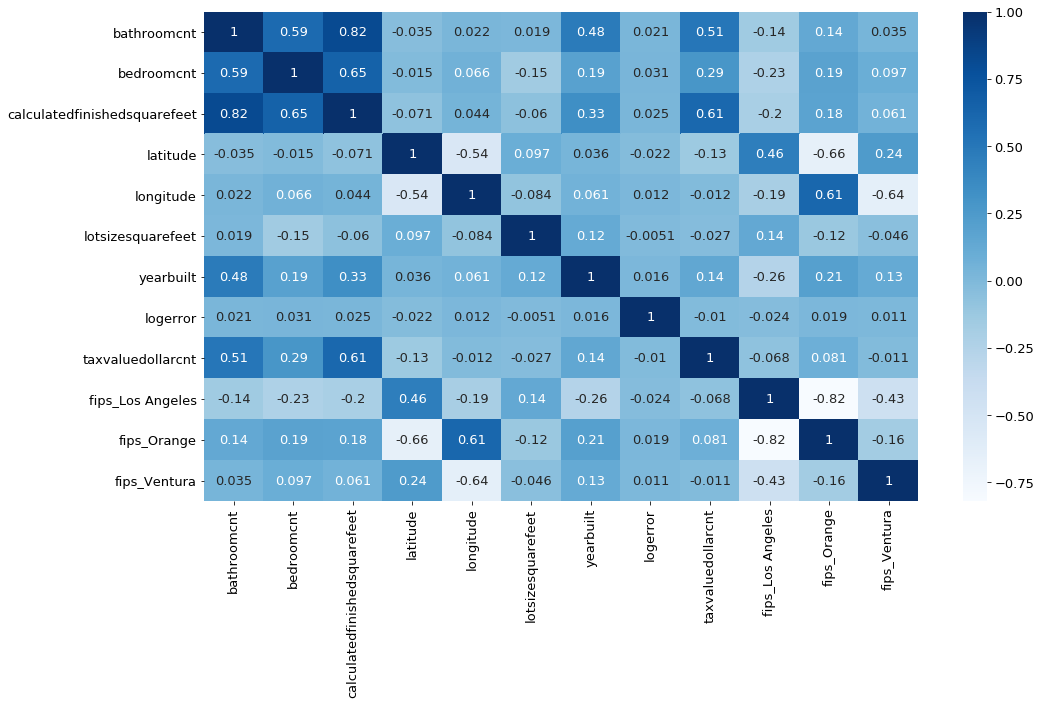

In [234]:
corr = train.corr()
sns.heatmap(corr, cmap='Blues', annot=True)

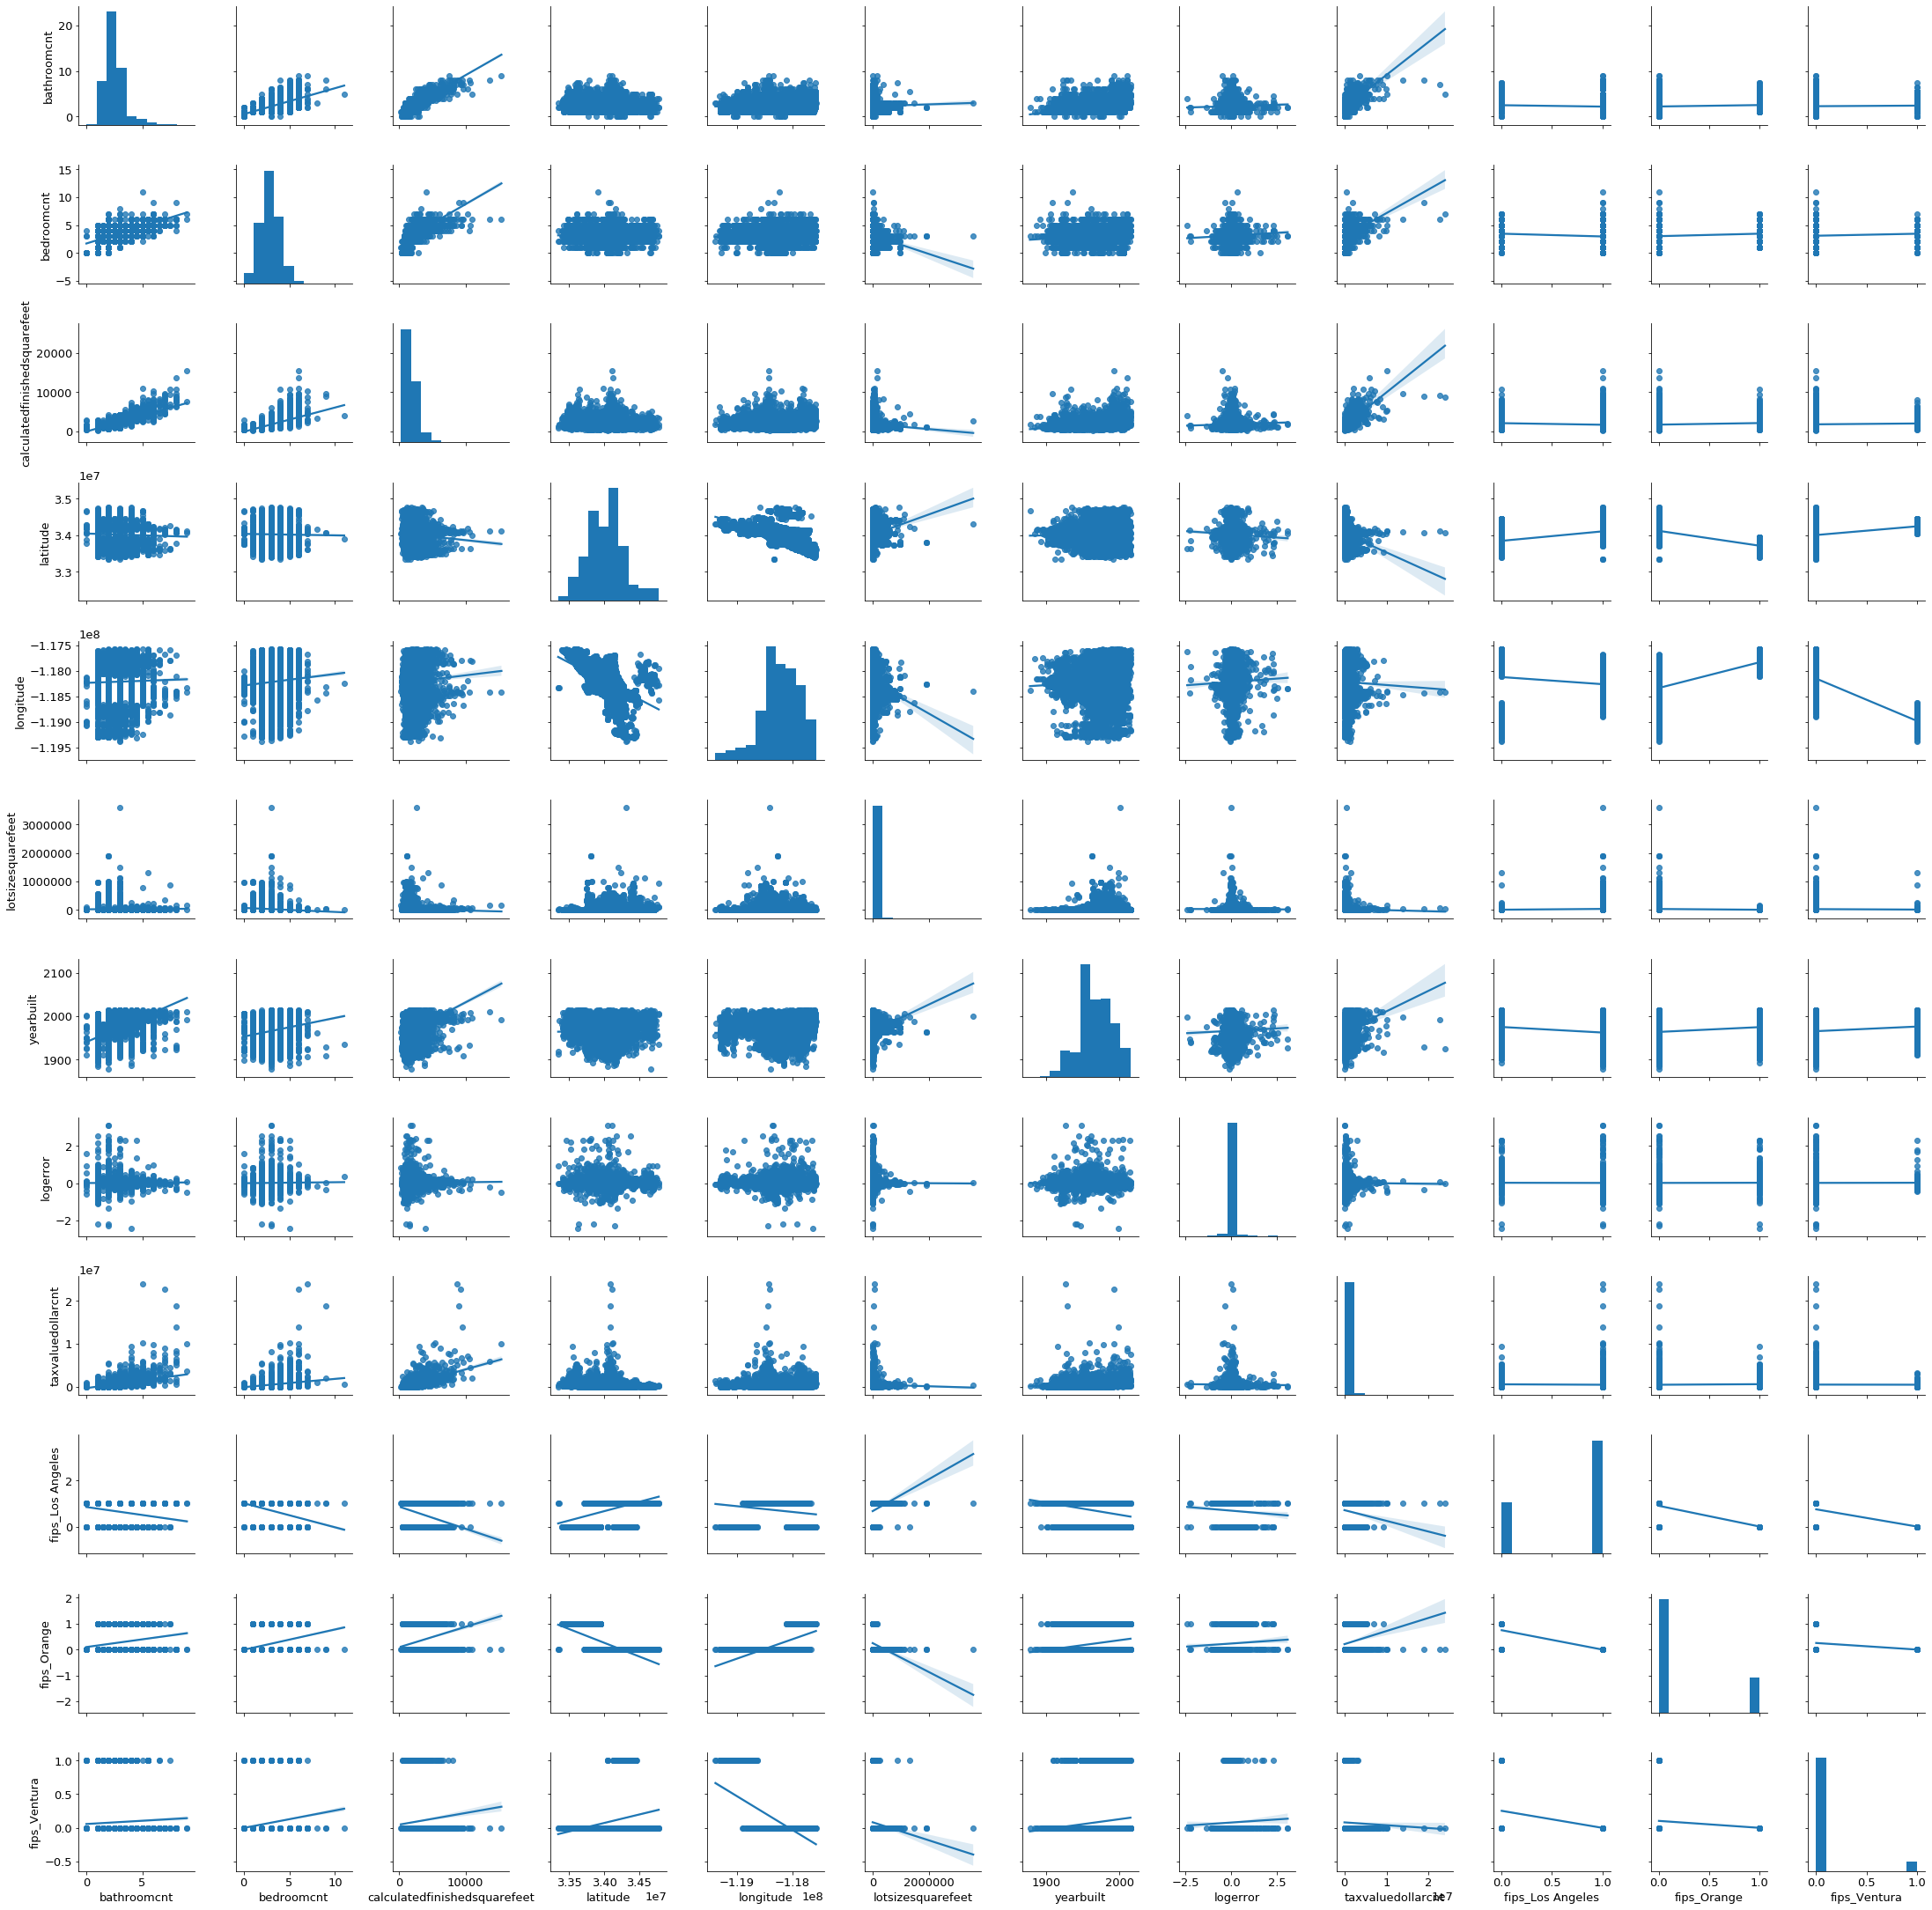

In [235]:
sns.pairplot(train, kind='reg')

### Hypothesis Test: Are the average house values in three counties sigfinicantly different from each other?

In [248]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12758 entries, 2459 to 7496
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   12758 non-null  float64
 1   bedroomcnt                    12758 non-null  float64
 2   calculatedfinishedsquarefeet  12758 non-null  float64
 3   latitude                      12758 non-null  float64
 4   longitude                     12758 non-null  float64
 5   lotsizesquarefeet             12758 non-null  float64
 6   yearbuilt                     12758 non-null  float64
 7   logerror                      12758 non-null  float64
 8   taxvaluedollarcnt             12758 non-null  float64
 9   fips_Los Angeles              12758 non-null  uint8  
 10  fips_Orange                   12758 non-null  uint8  
 11  fips_Ventura                  12758 non-null  uint8  
dtypes: float64(9), uint8(3)
memory usage: 1.6 MB


In [252]:
# Create masks values for three counties

mask_LA = train['fips_Los Angeles'] == 1
train_LA = train[mask_LA]

mask_orange = train['fips_Orange'] == 1
train_orange = train[mask_orange]

mask_ventura = train['fips_Ventura'] == 1
train_ventura = train[mask_ventura]

train_LA.shape, train_orange.shape, train_ventura.shape

((8768, 12), (2983, 12), (1007, 12))

#### Hypothesis Test 1: Are house value in Los Angeles county higher than the average in three counties?
$H_0$: The house values in Log Angeles county are the same as the average in three counties.<br>
$H_a$: The house values in Log Angeles county are different as the average in three counties.<br>
$alpha$ = 0.05

In [254]:
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,yearbuilt,logerror,taxvaluedollarcnt,fips_Los Angeles,fips_Orange,fips_Ventura
2459,3.0,3.0,2279.0,34121453.0,-118083479.0,9505.0,1948.0,-0.009300,1066356.0,1,0,0
13744,2.0,3.0,1477.0,34084794.0,-117914745.0,8245.0,1953.0,-0.023016,74087.0,1,0,0
15417,3.0,3.0,2895.0,34627416.0,-118185186.0,118977.0,2007.0,0.008795,566600.0,1,0,0
3257,1.0,2.0,795.0,34142400.0,-117917000.0,29390.0,1979.0,-0.026826,218000.0,1,0,0
3093,2.0,2.0,974.0,34212886.0,-118431196.0,6116.0,1951.0,-0.086502,203860.0,1,0,0


Text(0.5, 1.0, 'House value in LA')

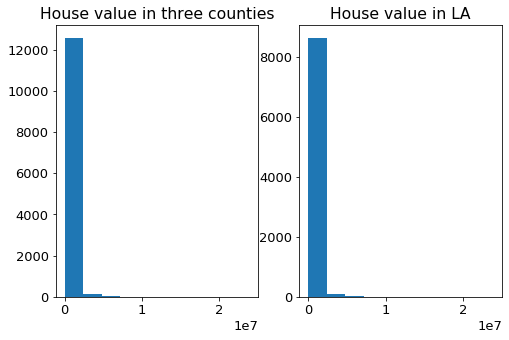

In [266]:
plt. figure(figsize=(8,5))

plt.subplot(1,2,1)

plt.hist(y_train)
plt.title('House value in three counties')

plt.subplot(1,2,2)
plt.hist(train_LA.taxvaluedollarcnt)
plt.title('House value in LA')

In [257]:
# Run one-sample test

from scipy import stats

t, p = stats.ttest_1samp(train_LA.taxvaluedollarcnt, y_train.mean())
t, p

(-3.994981531051578, 6.522844766264357e-05)

**Takeaways**
- The house values in Log Angeles county are sigfinicant lower than the average in three counties.

### Hypothesis Test 2: Are house value in Orange county higher than the average in three counties?
$H_0$: The house values in Orange county are the same as the average in three counties.<br>
$H_a$: The house values in Orange county are different as the average in three counties.<br>
$alpha$ = 0.05

Text(0.5, 1.0, 'House value in Orange')

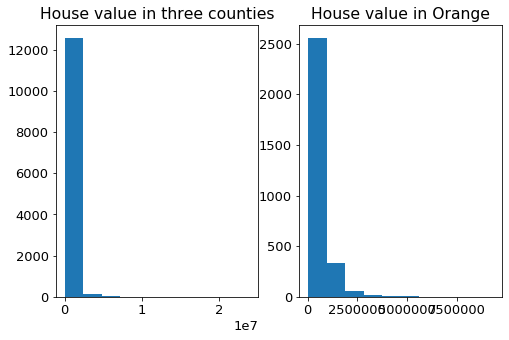

In [262]:
plt. figure(figsize=(8,5))

plt.subplot(1,2,1)

plt.hist(y_train)
plt.title('House value in three counties')

plt.subplot(1,2,2)
plt.hist(train_orange.taxvaluedollarcnt)
plt.title('House value in Orange')

In [263]:
t, p = stats.ttest_1samp(train_orange.taxvaluedollarcnt, y_train.mean())
t, p

(9.28687961088771, 2.971250881801298e-20)

**Takeaways**
- The house values in Orange county are sigfinicant higher than the average in three counties.

### Hypothesis Test 3: Are house value in Ventura county higher than the average in three counties?
$H_0$: The house values in Ventura county are the same as the average in three counties.<br>
$H_a$: The house values in Ventura county are different as the average in three counties.<br>
$alpha$ = 0.05

Text(0.5, 1.0, 'House value in Ventura')

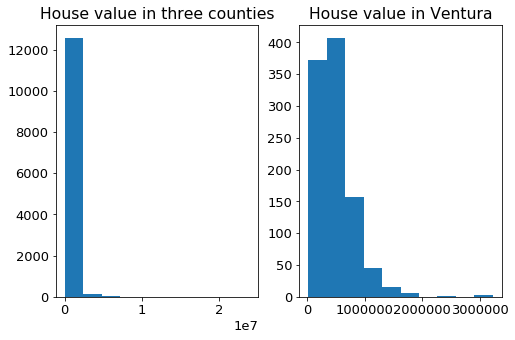

In [264]:
plt. figure(figsize=(8,5))

plt.subplot(1,2,1)

plt.hist(y_train)
plt.title('House value in three counties')

plt.subplot(1,2,2)
plt.hist(train_ventura.taxvaluedollarcnt)
plt.title('House value in Ventura')

In [265]:
t, p = stats.ttest_1samp(train_ventura.taxvaluedollarcnt, y_train.mean())
t, p

(-2.2838439903955328, 0.022588394649575308)

**Takeaways**
- The house values in Ventura county are sigfinicant lower than the average in three counties.

In [278]:
# Compute the variances in taxvaluedollarcnt in three counties

train_LA.taxvaluedollarcnt.var(), train_orange.taxvaluedollarcnt.var(), train_ventura.taxvaluedollarcnt.var()

(532316453170.5187, 344347658587.9691, 116278914677.73328)

In [267]:
t, p = stats.ttest_ind(train_LA.taxvaluedollarcnt, train_orange.taxvaluedollarcnt, equal_var=False)
t, p

(-9.863376684858562, 8.743834568493588e-23)

**Takeaways**
- The house values in LA county are sigfinicant lower than the average in Orange county.

In [269]:
t, p = stats.ttest_ind(train_ventura.taxvaluedollarcnt, train_orange.taxvaluedollarcnt, equal_var=False)
t, p

(-8.181373319517133, 4.094549725804095e-16)

**Takeaways**
- The house values in Ventura county are sigfinicant lower than the average in Orange county.

In [270]:
t, p = stats.ttest_ind(train_LA.taxvaluedollarcnt, train_ventura.taxvaluedollarcnt, equal_var=False)
t, p

(-0.49620562320223693, 0.6197973865417374)

**Takeaways**
- The house values in LA county are the same as the average in Ventura county.

### Feature Engineering on training dataset

In [295]:
import features

f_features = features.select_kbest(X_train_scaled, y_train, 6)
f_features

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'yearbuilt',
 'fips_Orange']

In [296]:
rfe_features = features.rfe(X_train_scaled, y_train, 6)
rfe_features

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'logerror']

### Modeling

### Set up baseline

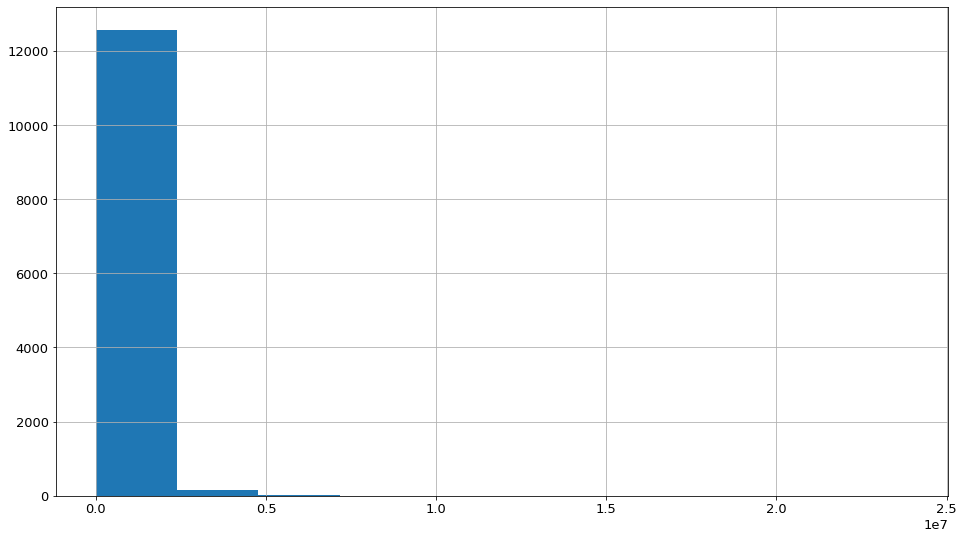

In [280]:
y_train.hist()

In [281]:
mean, median = y_train.agg(['mean', 'median'])
mean, median

(509820.91950148926, 364401.0)

In [282]:
# Compute baseline prediction using mean

baseline = np.array([mean]*y_train.size)
baseline[:5], len(baseline)

(array([509820.91950149, 509820.91950149, 509820.91950149, 509820.91950149,
        509820.91950149]),
 12758)

In [285]:
# Compute baseline sse

baseline_residual = y_train - mean
baseline_sse = (baseline_residual**2).sum()
baseline_sse

5849440514532679.0

In [288]:
# Compute baseline mse

baseline_mse = baseline_sse/y_train.size
baseline_mse

458491966964.4677

In [290]:
# Compute baseline rmse

baseline_rmse = mean_squared_error(y_train, baseline)**1/2
baseline_rmse

229245983482.23386

### Test 3 different algorithms for all six features

- LinearRegression
- LassoLars
- Poly(2nd degree)

In [298]:
# Create X_train_scaled for f_features and rfe_features

X_train_scaled_f = X_train_scaled[f_features]
X_train_scaled_rfe = X_train_scaled[rfe_features]

In [299]:
X_train_scaled_f.head(1)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,yearbuilt,fips_Orange
2459,0.333333,0.272727,0.133943,0.542534,0.510949,0.0


In [339]:
X_train_scaled_rfe.head(1)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,logerror
2459,0.333333,0.272727,0.133943,0.542534,0.718569,0.435243


In [301]:
y_train.head(1)

2459    1066356.0
Name: taxvaluedollarcnt, dtype: float64

In [309]:
def plot_residuals(actual, predicted, feature):
    """
    Returns the scatterplot of actural y in horizontal axis and residuals in vertical axis
    Parameters: actural y(df.se), predicted y(df.se), feature(str)
    Prerequisite: call function evaluate_slr
    """
    residuals = actual - predicted
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title(f'Actual vs Residual on {feature}')
    return plt.gca()

In [377]:
def plot_residuals_percentage(actual, predicted, feature):
    """
    Returns the scatterplot of actural y in horizontal axis and residuals in vertical axis
    Parameters: actural y(df.se), predicted y(df.se), feature(str)
    Prerequisite: call function evaluate_slr
    """
    residuals = actual - predicted
    residuals_percentage = residuals/actual
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals_percentage)
    plt.ylabel('residual ($y - \hat{y}$)%')
    plt.xlabel('actual value ($y$)')
    plt.title(f'Actual vs Residual% on {feature}')
    return plt.gca()

### LinearRegression
- f_features
- rfe_features

In [416]:
# Create lm object for 2nd iteration

lm2 = LinearRegression(normalize=True)
lm2

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [417]:
# Fit train dataset with f_features, predict and calculate the lm_rmse

lm_f = lm2.fit(X_train_scaled_f, y_train)
lm_pred_f = lm_f.predict(X_train_scaled_f)
lm_rmse_f = mean_squared_error(y_train, lm_pred_f)**1/2

lm_rmse_f

134918766070.42451

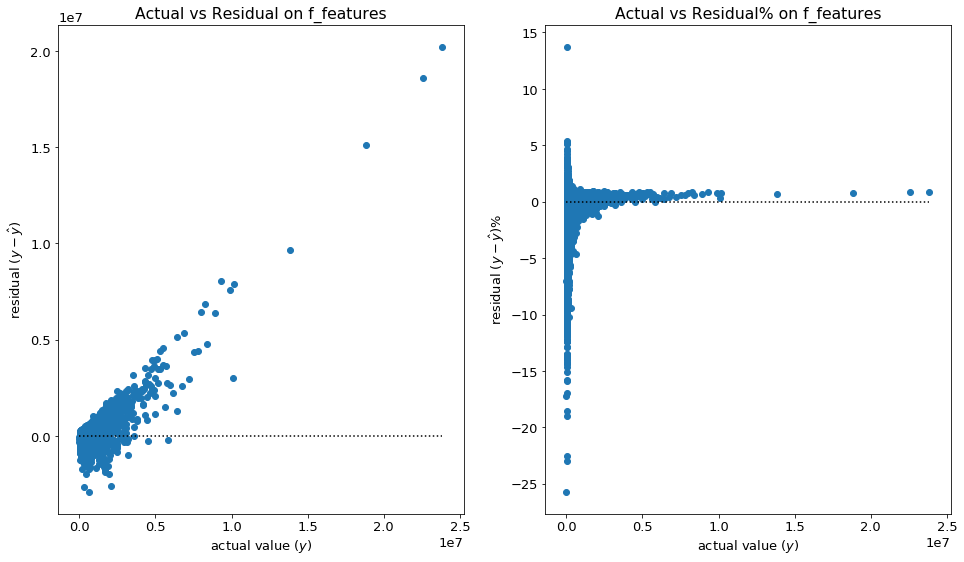

In [418]:
# Residual plot

plt.subplot(121)
plot_residuals(y_train, lm_pred_f, 'f_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lm_pred_f, 'f_features')

In [419]:
# Fit train dataset with rfe_features, predict and calculate the lm_rmse

lm_rfe = lm2.fit(X_train_scaled_rfe, y_train)
lm_pred_rfe = lm_rfe.predict(X_train_scaled_rfe)
lm_rmse_rfe = mean_squared_error(y_train, lm_pred_rfe)**1/2

lm_rmse_rfe

135730219828.62453

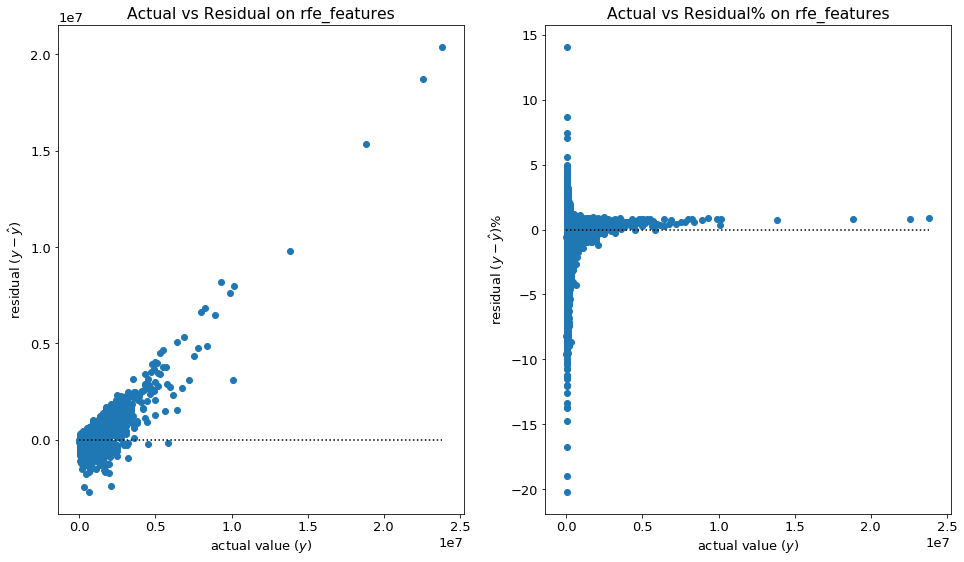

In [420]:
plt.subplot(121)
plot_residuals(y_train, lm_pred_rfe, 'rfe_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lm_pred_rfe, 'rfe_features')

### LassoLars()
- f_features
- rfe_features

In [421]:
# Create lars object (alpha=0.1) for 2nd iteration

lars2 = LassoLars(alpha=0.1)
lars2

LassoLars(alpha=0.1, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False)

In [422]:
# Fit train dataset with f_features, predict and calculate the rmse

lars_f = lars2.fit(X_train_scaled_f, y_train)
lars_pred_f = lars_f.predict(X_train_scaled_f)
lars_rmse_f = mean_squared_error(y_train, lars_pred_f)**1/2

lars_rmse_f

134918766887.39525

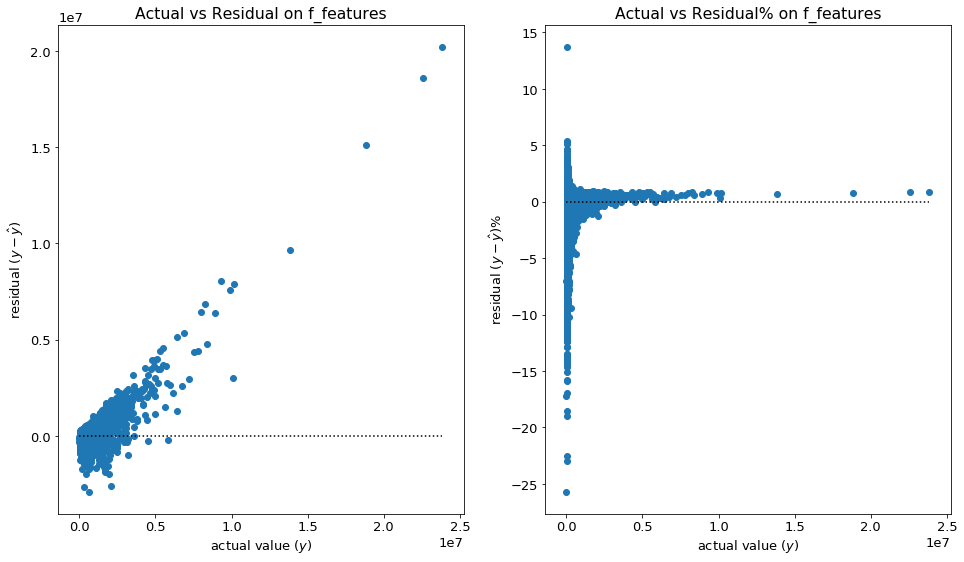

In [423]:
plt.subplot(121)
plot_residuals(y_train, lars_pred_f, 'f_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lars_pred_f, 'f_features')

In [424]:
# Fit train dataset with rfe_features, predict and calculate the lm_rmse

lars_rfe = lars2.fit(X_train_scaled_rfe, y_train)
lars_pred_rfe = lars_rfe.predict(X_train_scaled_rfe)
lars_rmse_rfe = mean_squared_error(y_train, lars_pred_rfe)**1/2

lars_rmse_rfe

135730220505.91127

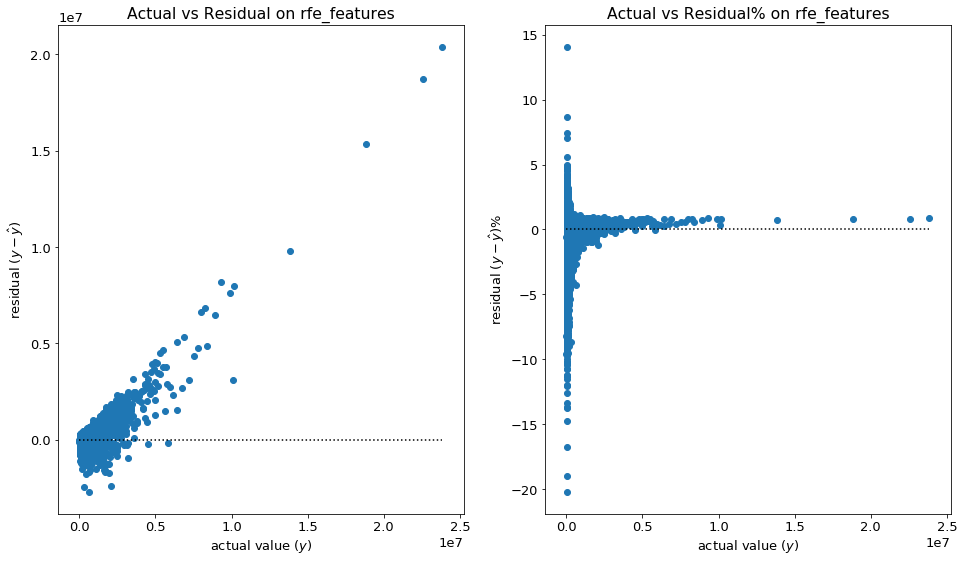

In [425]:
plt.subplot(121)
plot_residuals(y_train, lars_pred_rfe, 'rfe_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lars_pred_rfe, 'rfe_features')

### Poly (2nd degress)
- f_features
- rfe_features

In [426]:
# Transform X_train_scaled_f and _rfe to squared.

pf2 = PolynomialFeatures(degree=2)
X_train_scaled_squared_f = pf2.fit_transform(X_train_scaled_f)
X_train_scaled_squared_rfe = pf2.fit_transform(X_train_scaled_rfe)

In [427]:
# Create lm_squared object

lm_squared2 = LinearRegression()

In [428]:
# Fit X_train_scaled_squared_f, predict and compute the rmse

lm_squared_f = lm_squared2.fit(X_train_scaled_squared_f, y_train)
lm_squared_pred_f = lm_squared_f.predict(X_train_scaled_squared_f)

lm_squared_rmse_f = mean_squared_error(y_train, lm_squared_pred_f)**1/2
lm_squared_rmse_f

119322214626.23409

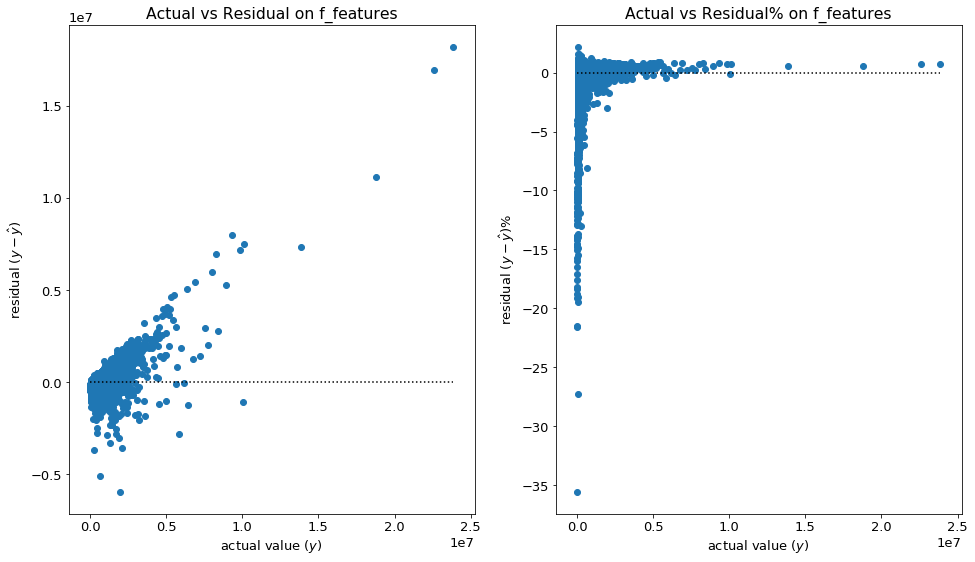

In [429]:
plt.subplot(121)
plot_residuals(y_train, lm_squared_pred_f, 'f_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lm_squared_pred_f, 'f_features')

In [430]:
# Fit X_train_scaled_squared_rfe, predict and compute the rmse

lm_squared_rfe = lm_squared2.fit(X_train_scaled_squared_rfe, y_train)
lm_squared_pred_rfe = lm_squared_rfe.predict(X_train_scaled_squared_rfe)

lm_squared_rmse_rfe = mean_squared_error(y_train, lm_squared_pred_rfe)**1/2
lm_squared_rmse_rfe

120110544376.84709

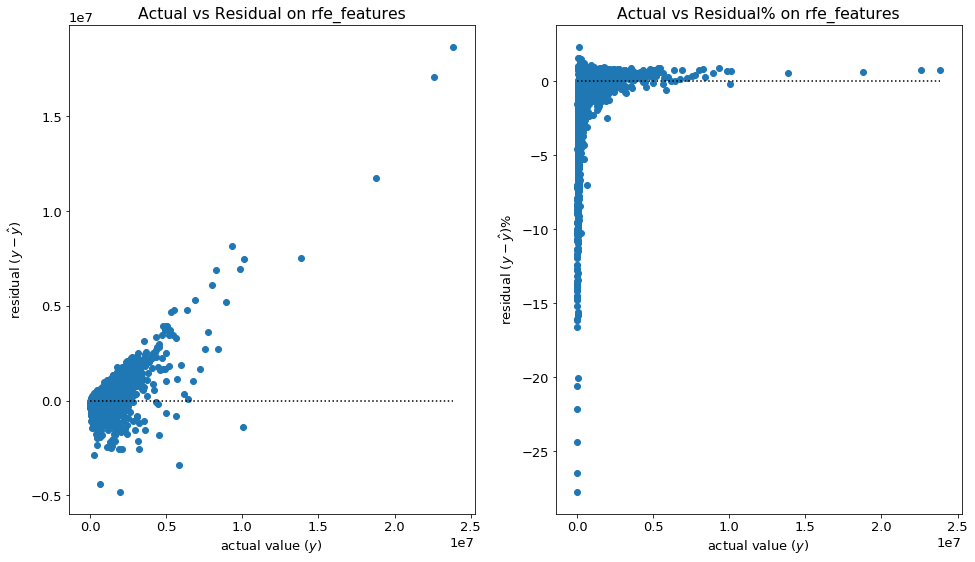

In [431]:
plt.subplot(121)
plot_residuals(y_train, lm_squared_pred_rfe, 'rfe_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lm_squared_pred_rfe, 'rfe_features')

### Summarize the RMSE of all 6 models

In [433]:
rmse_values = [baseline_rmse,
               lm_rmse_f, lm_rmse_rfe, 
               lars_rmse_f, lars_rmse_rfe, 
               lm_squared_rmse_f, lm_squared_rmse_rfe]
rmse_index = ['baseline_rmse',
              'lm_rmse_f', 'lm_rmse_rfe',
              'lars_rmse_f', 'lars_rmse_rfe',
              'lm_squared_rmse_f', 'lm_squared_rmse_rfe']

rmse = pd.DataFrame(rmse_values, index=rmse_index, columns=['RMSE'])
rmse.sort_values(by='RMSE')

,RMSE
lm_squared_rmse_f,1.193222e+11
lm_squared_rmse_rfe,1.201105e+11
lm_rmse_f,1.349188e+11
lars_rmse_f,1.349188e+11
lm_rmse_rfe,1.357302e+11
lars_rmse_rfe,1.357302e+11
baseline_rmse,2.292460e+11


### Poly (n degress)
- f_features
- rfe_features

In [390]:
def polyfeatures(X_train_scaled, y_train, n):
    pf = PolynomialFeatures(degree=n)
    X_train_scaled = pf.fit_transform(X_train_scaled)
    lm = LinearRegression()
    lm = lm.fit(X_train_scaled, y_train)
    lm_pred = lm.predict(X_train_scaled)
    lm_rmse = mean_squared_error(y_train, lm_pred)**1/2
    return lm_rmse

In [401]:
y_train.head()

2459     1066356.0
13744      74087.0
15417     566600.0
3257      218000.0
3093      203860.0
Name: taxvaluedollarcnt, dtype: float64

In [400]:
X_train_scaled_f.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,yearbuilt,fips_Orange
2459,0.333333,0.272727,0.133943,0.542534,0.510949,0.0
13744,0.222222,0.272727,0.081207,0.517055,0.547445,0.0
15417,0.333333,0.272727,0.174448,0.894189,0.941606,0.0
3257,0.111111,0.181818,0.036362,0.557093,0.737226,0.0
3093,0.222222,0.181818,0.048133,0.606082,0.532847,0.0


In [404]:
X_train_scaled = X_train_scaled_f

rmse_poly_n_f = []
degrees = [1,2,3,4,5,6]

for degree in degrees:
    rmse_poly_n_f.append(polyfeatures(X_train_scaled, y_train, degree))
    
rmse_poly_n_f = pd.DataFrame(rmse_poly_n_f, index=degrees, columns=['RMSE for Poly'])
rmse_poly_n_f

,RMSE for Poly
1,1.349188e+11
2,1.193222e+11
3,1.081701e+11
4,9.058231e+10
5,7.229370e+10
6,5.989166e+10


In [402]:
X_train_scaled_rfe.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,logerror
2459,0.333333,0.272727,0.133943,0.542534,0.718569,0.435243
13744,0.222222,0.272727,0.081207,0.517055,0.811488,0.432752
15417,0.333333,0.272727,0.174448,0.894189,0.662560,0.438529
3257,0.111111,0.181818,0.036362,0.557093,0.810246,0.432060
3093,0.222222,0.181818,0.048133,0.606082,0.527087,0.421225


In [405]:
X_train_scaled = X_train_scaled_rfe

rmse_poly_n_rfe = []
degrees = [1,2,3,4,5,6]

for degree in degrees:
    rmse_poly_n_rfe.append(polyfeatures(X_train_scaled, y_train, degree))
    
rmse_poly_n_rfe = pd.DataFrame(rmse_poly_n_rfe, index=degrees, columns=['RMSE for Poly'])
rmse_poly_n_rfe

,RMSE for Poly
1,1.357302e+11
2,1.201105e+11
3,1.081907e+11
4,9.308819e+10
5,7.014800e+10
6,5.520195e+10


### Add Poly (3rd degree)
- f_features
- rfe_features

In [434]:
# Transform X_train_scaled_f and _rfe to cubed

pf3 = PolynomialFeatures(degree=3)

pf_3_f = pf3.fit(X_train_scaled_f)
X_train_scaled_cubed_f = pf_3.transform(X_train_scaled_f)

pf_3_rfe = pf3.fit(X_train_scaled_rfe)
X_train_scaled_cubed_rfe = pf_3.transform(X_train_scaled_rfe)

In [435]:
# Fit f_features scaled cubed dataset to LinearRegression

lm_cubed = LinearRegression()

lm_cubed_f = lm_cubed.fit(X_train_scaled_cubed_f, y_train)
lm_cubed_pred_f = lm_cubed_f.predict(X_train_scaled_cubed_f)

lm_cubed_rmse_f = mean_squared_error(y_train, lm_cubed_pred_f)**1/2
lm_cubed_rmse_f

108170149369.93443

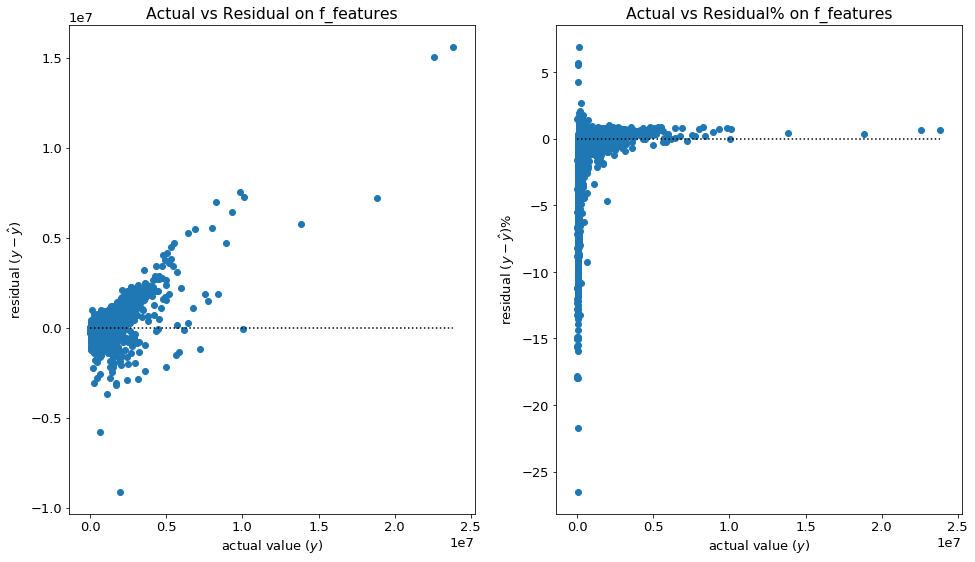

In [436]:
plt.subplot(121)
plot_residuals(y_train, lm_cubed_pred_f, 'f_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lm_cubed_pred_f, 'f_features')

In [437]:
# Fit rfe_features scaled cubed dataset to LinearRegression

lm_cubed_rfe = lm_cubed.fit(X_train_scaled_cubed_rfe, y_train)
lm_cubed_pred_rfe = lm_cubed_rfe.predict(X_train_scaled_cubed_rfe)

lm_cubed_rmse_rfe = mean_squared_error(y_train, lm_cubed_pred_rfe)**1/2
lm_cubed_rmse_rfe

108190735774.3979

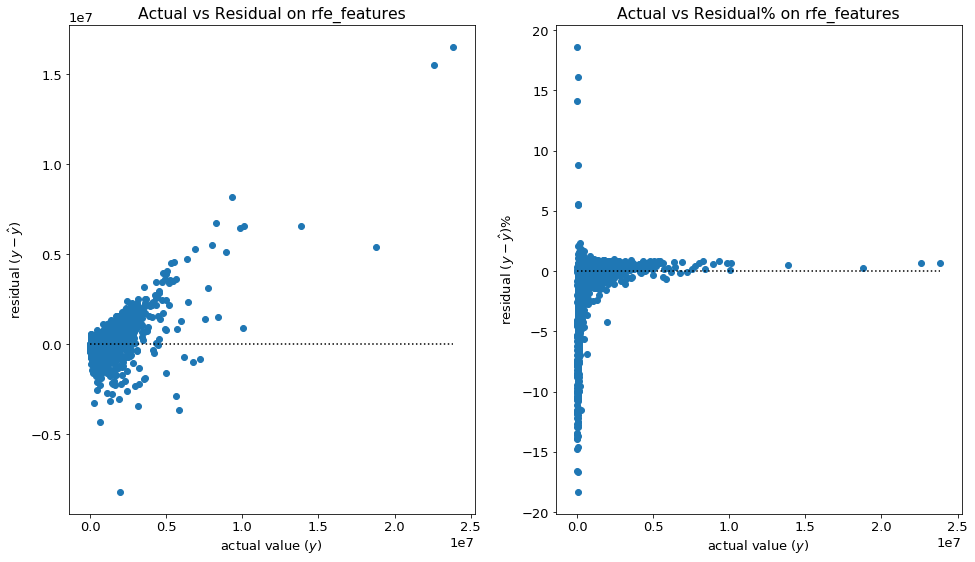

In [452]:
plt.subplot(121)
plot_residuals(y_train, lm_cubed_pred_rfe, 'rfe_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lm_cubed_pred_rfe, 'rfe_features')

### Update the RMSE of all 8 models (include lm_cube_rmse)

In [441]:
rmse_values = [baseline_rmse,
               lm_rmse_f, lm_rmse_rfe, 
               lars_rmse_f, lars_rmse_rfe, 
               lm_squared_rmse_f, lm_squared_rmse_rfe,
               lm_cubed_rmse_f, lm_cubed_rmse_rfe]
rmse_index = ['baseline_rmse',
              'lm_rmse_f', 'lm_rmse_rfe',
              'lars_rmse_f', 'lars_rmse_rfe',
              'lm_squared_rmse_f', 'lm_squared_rmse_rfe',
              'lm_cubed_rmse_f', 'lm_cubed_rmse_rfe']

rmse = pd.DataFrame(rmse_values, index=rmse_index, columns=['Train_RMSE'])
rmse.sort_values(by='Train_RMSE')

,Train_RMSE
lm_cubed_rmse_f,1.081701e+11
lm_cubed_rmse_rfe,1.081907e+11
lm_squared_rmse_f,1.193222e+11
lm_squared_rmse_rfe,1.201105e+11
lm_rmse_f,1.349188e+11
lars_rmse_f,1.349188e+11
lm_rmse_rfe,1.357302e+11
lars_rmse_rfe,1.357302e+11
baseline_rmse,2.292460e+11


### Validate top 4 models

In [445]:
X_validate_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3190 entries, 8847 to 7353
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   3190 non-null   float64
 1   bedroomcnt                    3190 non-null   float64
 2   calculatedfinishedsquarefeet  3190 non-null   float64
 3   latitude                      3190 non-null   float64
 4   longitude                     3190 non-null   float64
 5   lotsizesquarefeet             3190 non-null   float64
 6   yearbuilt                     3190 non-null   float64
 7   logerror                      3190 non-null   float64
 8   fips_Los Angeles              3190 non-null   float64
 9   fips_Orange                   3190 non-null   float64
 10  fips_Ventura                  3190 non-null   float64
dtypes: float64(11)
memory usage: 299.1 KB


In [446]:
X_validate_scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,yearbuilt,logerror,fips_Los Angeles,fips_Orange,fips_Ventura
8847,0.500000,0.454545,0.204235,0.621782,0.327459,0.002723,0.883212,0.433959,0.0,0.0,1.0
14320,0.222222,0.272727,0.062533,0.667667,0.523669,0.001627,0.576642,0.437511,1.0,0.0,0.0
16958,0.166667,0.272727,0.108561,0.591762,0.293620,0.005751,0.613139,0.440761,0.0,0.0,1.0
17680,0.111111,0.090909,0.030839,0.427750,0.524441,0.004904,0.678832,0.436007,1.0,0.0,0.0
1421,0.166667,0.363636,0.088506,0.277527,0.840811,0.002261,0.562044,0.441631,0.0,1.0,0.0


In [449]:
y_validate.head()

8847     108674.0
14320    451785.0
16958    392425.0
17680    227809.0
1421     383325.0
Name: taxvaluedollarcnt, dtype: float64

In [444]:
f_features, rfe_features

(['bathroomcnt',
  'bedroomcnt',
  'calculatedfinishedsquarefeet',
  'latitude',
  'yearbuilt',
  'fips_Orange'],
 ['bathroomcnt',
  'bedroomcnt',
  'calculatedfinishedsquarefeet',
  'latitude',
  'longitude',
  'logerror'])

In [447]:
X_validate_scaled_f = X_validate_scaled[f_features]
X_validate_scaled_rfe = X_validate_scaled[rfe_features]

### Poly (3rd degree)
- f_features
- rfe_features

In [448]:
# Transform X_validate_scaled_f and _rfe to cubed.

X_validate_scaled_cubed_f = pf3.transform(X_validate_scaled_f)
X_validate_scaled_cubed_rfe = pf3.transform(X_validate_scaled_rfe)

In [479]:
# Fit X_validate_scaled_cubed_f, predict and compute the rmse

lm_cubed_pred_f = lm_cubed_f.predict(X_validate_scaled_cubed_f)

lm_cubed_rmse_f = mean_squared_error(y_validate, lm_cubed_pred_f)**1/2
lm_cubed_rmse_f

1364907745741.827

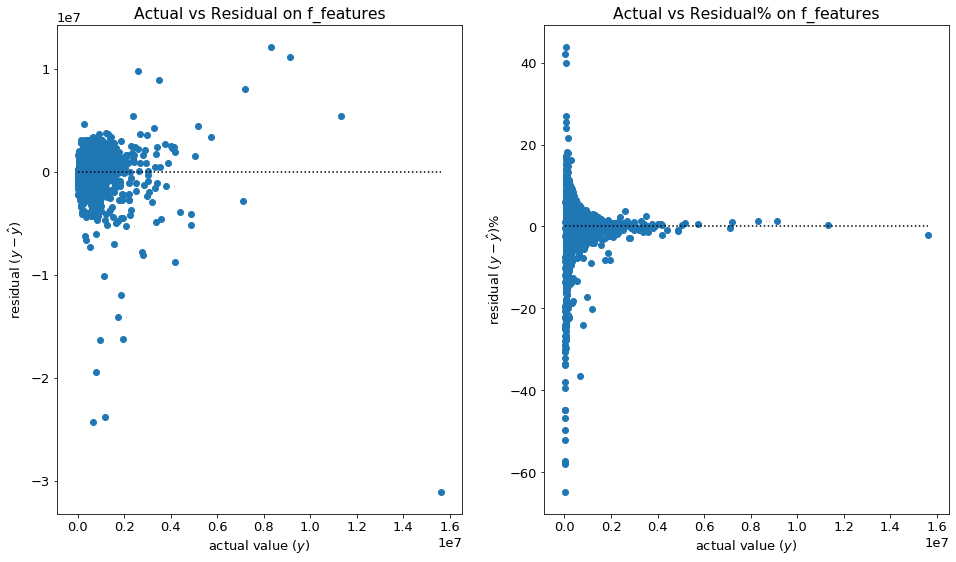

In [455]:
plt.subplot(121)
plot_residuals(y_validate, lm_cubed_pred_f, 'f_features')

plt.subplot(122)
plot_residuals_percentage(y_validate, lm_cubed_pred_f, 'f_features')

In [480]:
# Fit X_validate_scaled_squared_rfe, predict and compute the rmse

lm_cubed_pred_rfe = lm_cubed_rfe.predict(X_validate_scaled_cubed_rfe)

lm_cubed_rmse_rfe = mean_squared_error(y_validate, lm_cubed_pred_rfe)**1/2
lm_cubed_rmse_rfe

141776770604.0419

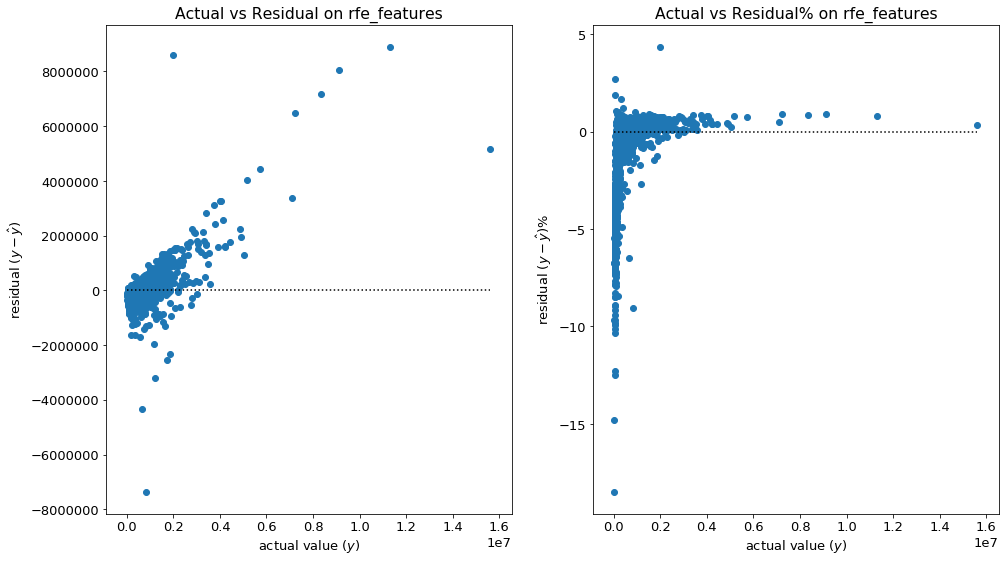

In [457]:
plt.subplot(121)
plot_residuals(y_validate, lm_cubed_pred_rfe, 'rfe_features')

plt.subplot(122)
plot_residuals_percentage(y_validate, lm_cubed_pred_rfe, 'rfe_features')

### Poly (2nd degree)
- f_features
- rfe_features

In [460]:
# Transform X_validate_scaled_f and _rfe to squared.

X_validate_scaled_squared_f = pf2.transform(X_validate_scaled_f)
X_validate_scaled_squared_rfe = pf2.transform(X_validate_scaled_rfe)

In [481]:
# Fit X_validate_scaled_squared_f, predict and compute the rmse

lm_squared_pred_f = lm_squared_f.predict(X_validate_scaled_squared_f)

lm_squared_rmse_f = mean_squared_error(y_validate, lm_squared_pred_f)**1/2
lm_squared_rmse_f

220455740265.8859

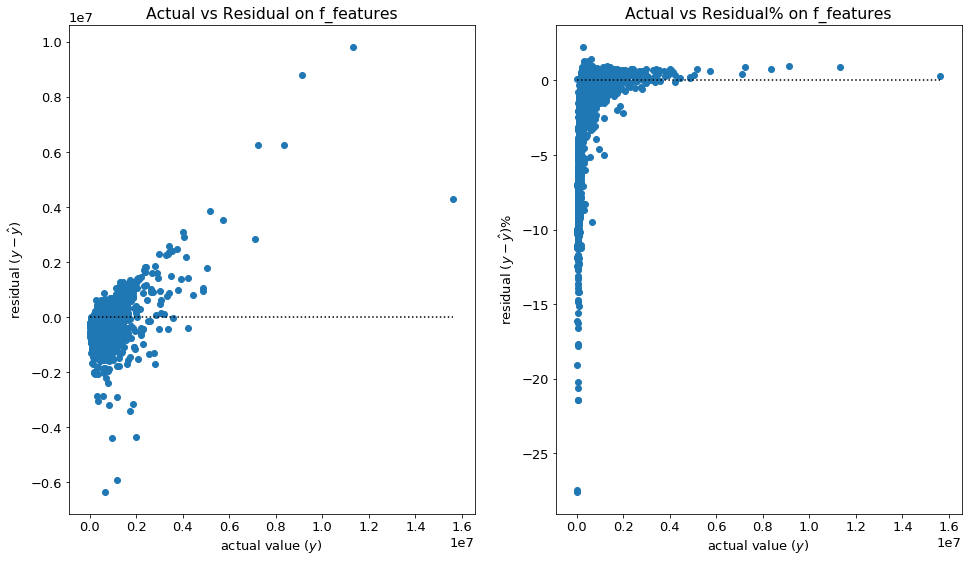

In [462]:
plt.subplot(121)
plot_residuals(y_validate, lm_squared_pred_f, 'f_features')

plt.subplot(122)
plot_residuals_percentage(y_validate, lm_squared_pred_f, 'f_features')

In [482]:
# Fit X_validate_scaled_squared_rfe, predict and compute the rmse

lm_squared_pred_rfe = lm_squared_rfe.predict(X_validate_scaled_squared_rfe)

lm_squared_rmse_rfe = mean_squared_error(y_validate, lm_squared_pred_rfe)**1/2
lm_squared_rmse_rfe

123440002607.95192

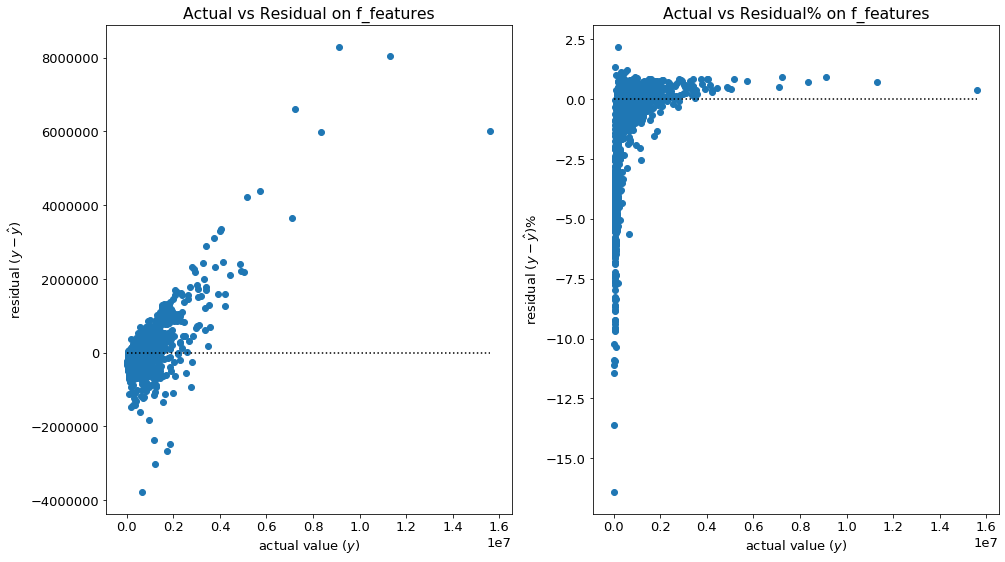

In [464]:
plt.subplot(121)
plot_residuals(y_validate, lm_squared_pred_rfe, 'f_features')

plt.subplot(122)
plot_residuals_percentage(y_validate, lm_squared_pred_rfe, 'f_features')

### Summarize RMSE_validate

In [483]:
rmse_values = [baseline_rmse,
               lm_squared_rmse_f, lm_squared_rmse_rfe,
               lm_cubed_rmse_f, lm_cubed_rmse_rfe]
rmse_index = ['baseline_rmse',
              'lm_squared_rmse_f', 'lm_squared_rmse_rfe',
              'lm_cubed_rmse_f', 'lm_cubed_rmse_rfe']

rmse_validate = pd.DataFrame(rmse_values, index=rmse_index, columns=['Validate_RMSE'])
rmse_validate.sort_values(by='Validate_RMSE')

,Validate_RMSE
lm_squared_rmse_rfe,1.234400e+11
lm_cubed_rmse_rfe,1.417768e+11
lm_squared_rmse_f,2.204557e+11
baseline_rmse,2.292460e+11
lm_cubed_rmse_f,1.364908e+12


### Test with the best model rfe_features with Poly(2nd) algorithm

In [466]:
# Check test dataset

X_test_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1772 entries, 7223 to 2277
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   1772 non-null   float64
 1   bedroomcnt                    1772 non-null   float64
 2   calculatedfinishedsquarefeet  1772 non-null   float64
 3   latitude                      1772 non-null   float64
 4   longitude                     1772 non-null   float64
 5   lotsizesquarefeet             1772 non-null   float64
 6   yearbuilt                     1772 non-null   float64
 7   logerror                      1772 non-null   float64
 8   fips_Los Angeles              1772 non-null   float64
 9   fips_Orange                   1772 non-null   float64
 10  fips_Ventura                  1772 non-null   float64
dtypes: float64(11)
memory usage: 166.1 KB


In [467]:
X_test_scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,yearbuilt,logerror,fips_Los Angeles,fips_Orange,fips_Ventura
7223,0.222222,0.363636,0.072199,0.283978,0.865605,0.002044,0.562044,0.440086,0.0,1.0,0.0
15042,0.333333,0.363636,0.150710,0.296214,0.881739,0.003014,0.627737,0.439369,0.0,1.0,0.0
14170,0.222222,0.363636,0.085679,0.358367,0.630202,0.001270,0.635036,0.427317,1.0,0.0,0.0
8692,0.277778,0.363636,0.134008,0.333382,0.743905,0.001562,0.715328,0.445995,0.0,1.0,0.0
5458,0.333333,0.454545,0.142491,0.382725,0.792408,0.002484,0.832117,0.441334,0.0,1.0,0.0


In [468]:
rfe_features

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'logerror']

In [469]:
X_test_scaled_rfe = X_test_scaled[rfe_features]
X_test_scaled_rfe.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,logerror
7223,0.222222,0.363636,0.072199,0.283978,0.865605,0.440086
15042,0.333333,0.363636,0.150710,0.296214,0.881739,0.439369
14170,0.222222,0.363636,0.085679,0.358367,0.630202,0.427317
8692,0.277778,0.363636,0.134008,0.333382,0.743905,0.445995
5458,0.333333,0.454545,0.142491,0.382725,0.792408,0.441334


In [470]:
y_test.head()

7223       72903.0
15042    1116775.0
14170      52344.0
8692      145546.0
5458      116643.0
Name: taxvaluedollarcnt, dtype: float64

In [471]:
# Transform X_test_scaled_rfe to squared

X_test_scaled_squared_rfe = pf2.transform(X_test_scaled_rfe)

In [472]:
lm_squared_pred_rfe = lm_squared_rfe.predict(X_test_scaled_squared_rfe)

lm_squared_rmse_rfe = mean_squared_error(y_test, lm_squared_pred_rfe)**1/2
lm_squared_rmse_rfe

126184619490.76459

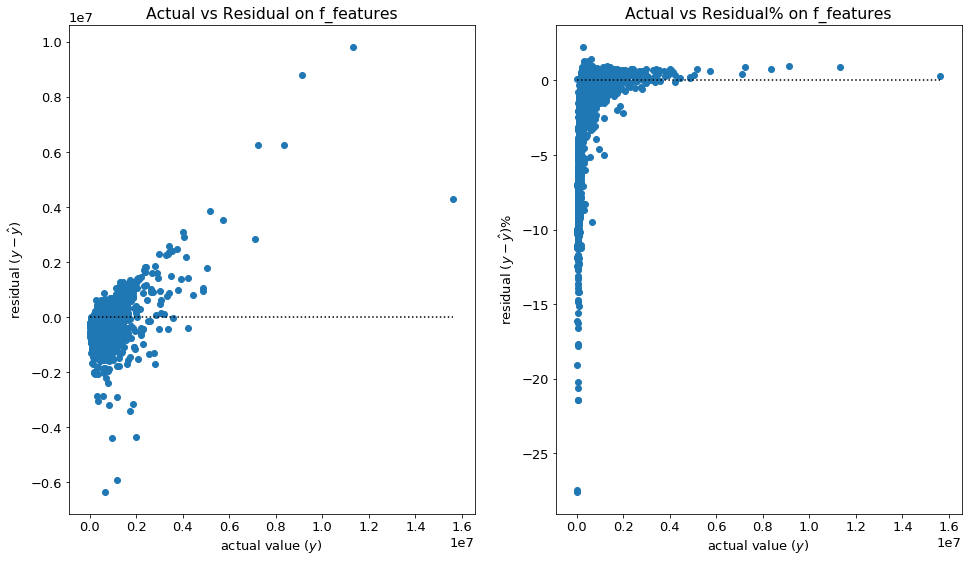

In [473]:
plt.subplot(121)
plot_residuals(y_validate, lm_squared_pred_f, 'f_features')

plt.subplot(122)
plot_residuals_percentage(y_validate, lm_squared_pred_f, 'f_features')

In [478]:
rmse_values = [baseline_rmse,lm_squared_rmse_rfe]
rmse_index = ['baseline_rmse','lm_squared_rmse_rfe']

rmse_test = pd.DataFrame(rmse_values, index=rmse_index, columns=['Test_RMSE'])
rmse_test.sort_values(by='Test_RMSE')

,Test_RMSE
lm_squared_rmse_rfe,1.261846e+11
baseline_rmse,2.292460e+11


In [485]:
rmse_overall = pd.concat([rmse, rmse_validate], axis=1)
rmse_overall = pd.concat([rmse_overall, rmse_test], axis=1)

rmse_overall.sort_values(by='Train_RMSE')

,Train_RMSE,Validate_RMSE,Test_RMSE
lm_cubed_rmse_f,1.081701e+11,1.364908e+12,NaN
lm_cubed_rmse_rfe,1.081907e+11,1.417768e+11,NaN
lm_squared_rmse_f,1.193222e+11,2.204557e+11,NaN
lm_squared_rmse_rfe,1.201105e+11,1.234400e+11,1.261846e+11
lm_rmse_f,1.349188e+11,NaN,NaN
lars_rmse_f,1.349188e+11,NaN,NaN
lm_rmse_rfe,1.357302e+11,NaN,NaN
lars_rmse_rfe,1.357302e+11,NaN,NaN
baseline_rmse,2.292460e+11,2.292460e+11,2.292460e+11
